In [1]:
!conda info


     active environment : base
    active env location : /home/emanuelezappala/anaconda3
            shell level : 1
       user config file : /home/emanuelezappala/.condarc
 populated config files : 
          conda version : 23.7.4
    conda-build version : 3.26.0
         python version : 3.11.4.final.0
       virtual packages : __archspec=1=x86_64
                          __cuda=12.2=0
                          __glibc=2.28=0
                          __linux=4.18.0=0
                          __unix=0=0
       base environment : /home/emanuelezappala/anaconda3  (writable)
      conda av data dir : /home/emanuelezappala/anaconda3/etc/conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /home/emanuelez

In [2]:
import GPUtil
GPUtil.getAvailable()

[0]

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
import logging
import warnings
from typing import Callable, Optional, Union
import os, argparse

import numpy as np
import torch
import torch_dct as dct
import torch.fft as fft

from scipy import integrate
import time
import pickle
from torch.utils.data import Dataset

logger = logging.getLogger("iesolver")
logger.setLevel(logging.WARNING)#(logging.DEBUG)

import matplotlib.pyplot as plt


import torchcubicspline
from torchcubicspline import(natural_cubic_spline_coeffs, 
                             NaturalCubicSpline)
                             
from torchdiffeq import odeint


from spectral_source.integrators import MonteCarlo 
mc = MonteCarlo()

from spectral_source.spectral_integrator import Chebyshev_nchannel, spectral_integrator_nchannels, spectral_integrator, Chebyshev
from spectral_source.spectral_ie_solver import Spectral_IE_solver
from spectral_source.spectral_experiments import spectral_experiment 

from spectral_source.utils import fix_random_seeds,to_np

if torch.cuda.is_available():  
    device = "cuda:0" 
else:  
    device = "cpu"
   
    
parser = argparse.ArgumentParser(description='Neural IE')
parser.add_argument('-root_path', metavar='DIR', default='',
                    help='path to dataset')
parser.add_argument('-dataset-name', default='stl10',
                    help='dataset name', choices=['acrobot_dataset'])
# parser.add_argument('-a', '--arch', metavar='ARCH', default='resnet18',
#                     choices=model_names,
#                     help='model architecture: ' +
#                          ' | '.join(model_names) +
#                          ' (default: resnet50)')
parser.add_argument('-j', '--workers', default=12, type=int, metavar='N',
                    help='number of data loading workers (default: 32)')
parser.add_argument('--epochs', default=3000, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('-b', '--batch_size', default=20, type=int,
                    metavar='N',
                    help='mini-batch size (default: 256), this is the total '
                         'batch size of all GPUs on the current node when '
                         'using Data Parallel or Distributed Data Parallel')
parser.add_argument('--lr', '--learning-rate', default=1e-4, type=float,
                    metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--wd', '--weight-decay', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)',
                    dest='weight_decay')
parser.add_argument('--seed', default=None, type=int,
                    help='seed for initializing training. ')
parser.add_argument('--disable-cuda', action='store_true',
                    help='Disable CUDA')
parser.add_argument('--fp16-precision', action='store_true',
                    help='Whether or not to use 16-bit precision GPU training.')

parser.add_argument('--out_dim', default=128, type=int,
                    help='feature dimension (default: 128)')
parser.add_argument('--log-every-n-steps', default=100, type=int,
                    help='Log every n steps')
parser.add_argument('--temperature', default=0.07, type=float,
                    help='softmax temperature (default: 0.07)')
parser.add_argument('--n-views', default=2, type=int, metavar='N',
                    help='Number of views for contrastive learning training.')
parser.add_argument('--gpu-index', default=0, type=int, help='Gpu index.')
parser.add_argument('--model', default='simclr', choices=['simclr','lipschitz_simclr','vae','gan'], 
                    help='Models to be used')
parser.add_argument('--mode', default='train', choices=['train','evaluate'], 
                    help='Set to ''evaluate'' if inference is desired')
parser.add_argument('--training_split', default=0.25,type=float, 
                    help='Fraction of the samples that will be used for validation')
parser.add_argument('--resume_from_checkpoint', default=None, 
                    help='Give string to run number. Ex: "run12"')
parser.add_argument('--plot_freq', default=1, type=int,help='')
parser.add_argument('--experiment_name', default=None,help='')
    
    

_StoreAction(option_strings=['--experiment_name'], dest='experiment_name', nargs=None, const=None, default=None, type=None, choices=None, required=False, help='', metavar=None)

In [5]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()

In [6]:
use_cuda

True

In [7]:
from functools import reduce
from spectral_source import kernels, integrators 
from spectral_source.utils import to_np
import random
import pickle
import time

In [8]:
args = parser.parse_args("")
args.model='spectral'
args.mode='train'
#args.mode='evaluate'
args.dataset_name = 'spectral_integral_equations'
args.seed = 7
args.experiment_name = 'IE_spirals'
args.plot_freq = 100
args.device = device
args.num_dim_plot = 2
args.lr = 1e-3
args.min_lr=1e-6
args.T_max = 51
args.plat_patience = 10
args.factor = 0.1
# args.temperature=0.001
#args.lr_scheduler = 'ReduceLROnPlateau'
args.lr_scheduler = 'CosineAnnealingLR'
#args.resume_from_checkpoint = 'run19'
fix_random_seeds(args.seed)
args.perturbation_to_obs0=None
args.training_split=0.2
args.smoothing_factor= .5
args.n_batch = 16
args.max_deg = 8  #maximum degree for Chebyshev polynomials used for the expansion
args.patience = 200
args.support_tensors=False
args.support_test=False
args.dim = 2
args.time_points = 100
args.f_nn = True
args.integrator_nn = False
args.chebyshev = True
args.max_iterations = 3
args.interpolation = False
args.channels = 2
args.N_MC = 1000

In [9]:
from spectral_source.spectral_functions import F_NN, F_func

In [10]:
Data = pickle.load(open("spectral_source/50_IE_Spirals.pkl","rb"))
Data = Data.to(device)

In [11]:
Data.shape

torch.Size([500, 100, 2])

In [12]:
if args.mode == 'train':
    Data = Data[:-96,...].to(device)
if args.mode == 'evaluate':
    Data = Data[-96:,...].to(device)

In [13]:
if args.interpolation and args.mode=='train':
    Data = Data[:,::2,:]

In [14]:
Data.shape

torch.Size([404, 100, 2])

In [15]:
# ts_integration = torch.linspace(0,1,Data.shape[-1])
# ts_integration = ts_integration[t_ids[0]]
# print(ts_integration)
# args.ts_integration = ts_integration
args.ts_integration = None

In [16]:
nCheb = Chebyshev_nchannel(max_deg=args.max_deg,n_batch=2,N_mc=args.N_MC,device=device)

In [17]:
def interpolator(time,obs):
        x = time
        y = obs
        coeffs = natural_cubic_spline_coeffs(x, y)
        interpolation = NaturalCubicSpline(coeffs)

        def output(point:torch.Tensor):
            return interpolation.evaluate(point)

        return output

In [18]:
times = torch.linspace(-1,1,100).to(device)

In [19]:
if args.interpolation:
    times = times[::2]

In [20]:
#interpolated_func = interpolator(times,Data)

In [21]:
def func_data(x):
    
    return interpolated_func(x)

In [22]:
times.shape

torch.Size([100])

In [23]:
if args.interpolation is False:
    init_ = 50
else:
    init_ = 25

In [24]:
X = torch.Tensor([]).to(device)
for i in range(0,Data.shape[0],2):
    interpolated_func = interpolator(times[::init_],Data[i:i+2,::init_,...])

    X_ = nCheb.expand(lambda x: interpolated_func(x))
    X = torch.cat([X,X_],0)
    del X_
print(X.shape)

torch.Size([404, 8, 2])


/home/emanuelezappala/anaconda3/lib/python3.11/site-packages/torchcubicspline/interpolate.py:277: UserWarning: torch.searchsorted(): boundary tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous boundary tensor if possible. This message will only appear once per program. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343970094/work/aten/src/ATen/native/BucketizationUtils.h:39.)
  index = torch.bucketize(t.detach(), self._t) - 1


In [25]:
interpolated_func = interpolator(times,Data[:2,...])
y_spir = interpolated_func(times)

In [26]:
y_spir.shape

torch.Size([2, 100, 2])

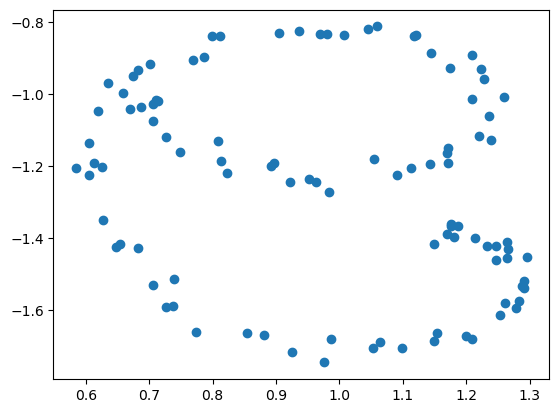

In [27]:
plt.scatter(to_np(y_spir)[0,:,0],to_np(y_spir)[0,:,1])

In [28]:
reconstruction_func = nCheb.inverse(X[:2,...])

In [29]:
reconstruction = reconstruction_func(times)

In [30]:
torch.abs(reconstruction - y_spir[...])

tensor([[[0.1083, 0.1346],
         [0.0138, 0.1077],
         [0.0395, 0.0114],
         [0.0650, 0.0205],
         [0.0956, 0.0294],
         [0.1238, 0.0475],
         [0.1595, 0.0875],
         [0.1823, 0.1138],
         [0.2163, 0.1217],
         [0.1951, 0.1078],
         [0.2100, 0.0894],
         [0.1886, 0.1333],
         [0.2021, 0.1221],
         [0.2315, 0.1120],
         [0.2224, 0.1907],
         [0.2257, 0.1750],
         [0.2288, 0.1960],
         [0.2212, 0.2548],
         [0.2316, 0.2426],
         [0.2117, 0.2907],
         [0.2291, 0.2701],
         [0.1906, 0.3855],
         [0.1959, 0.3933],
         [0.1669, 0.4037],
         [0.1796, 0.4453],
         [0.1126, 0.4703],
         [0.1671, 0.5103],
         [0.1412, 0.5342],
         [0.0965, 0.5347],
         [0.1071, 0.6245],
         [0.0772, 0.6212],
         [0.0278, 0.5924],
         [0.0741, 0.6228],
         [0.0119, 0.6357],
         [0.0293, 0.5868],
         [0.0227, 0.6096],
         [0.0082, 0.5520],
 

In [31]:
torch.abs(reconstruction - y_spir[...]).min(), torch.abs(reconstruction - y_spir[...]).max(), torch.abs(reconstruction - y_spir[...]).mean()

(tensor(0.0016, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.9476, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(0.3214, device='cuda:0', grad_fn=<MeanBackward0>))

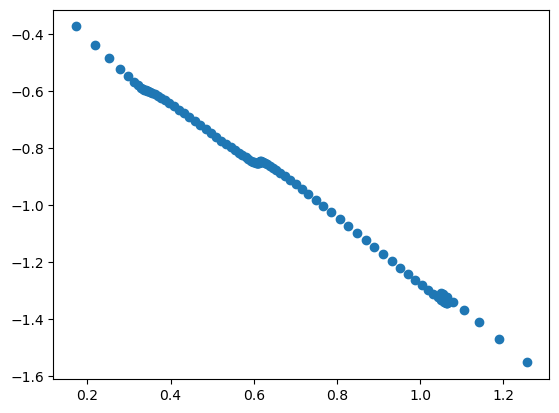

In [32]:
plt.scatter(to_np(reconstruction)[0,:,0],to_np(reconstruction)[0,:,1])

In [33]:
spectral_coeff = X

In [34]:
spectral_integrator = spectral_integrator_nchannels(
                      [args.n_batch]+[X.shape[1]]+[X.shape[i] for i in range(1,len(X.shape))],device=device
                      )

In [35]:
spectral_coeff.shape

torch.Size([404, 8, 2])

In [36]:
spectral_coeff = spectral_coeff.detach()

In [37]:
#model = F_NN(2*(args.max_deg+1),2*args.max_deg,2*args.max_deg,[4]).to(device)
model = F_NN(2*(args.max_deg+1),2*args.max_deg,2*args.max_deg,[100,100,100]).to(device)

In [38]:
f_func = F_func(2,2,[100,100,100]).to(device)

In [39]:
times = torch.linspace(-1,1,100).to(device)
if args.interpolation:
    times = times[::2]

In [40]:
nCheb = Chebyshev_nchannel(max_deg=args.max_deg,n_batch=args.n_batch,N_mc=args.N_MC,device=device)

In [41]:
p_shapes = []
flat_parameters = []
for p in model.parameters():
    p_shapes.append(p.size())
    flat_parameters.append(p.flatten())
all_parameters = torch.cat(flat_parameters)

In [42]:
all_parameters.shape

torch.Size([47232])

In [43]:
if args.f_nn is True:    
    p_shapes = []
    flat_parameters = []
    for p in f_func.parameters():
        p_shapes.append(p.size())
        flat_parameters.append(p.flatten())
    all_parameters = torch.cat(flat_parameters)
print(all_parameters.shape)

torch.Size([20702])


In [44]:
times.shape

torch.Size([100])

In [ ]:
spectral_experiment(model, Data, spectral_coeff, interpolator, times, args, chebyshev_transform=nCheb, cosine_transform=None, spectral_integrator=spectral_integrator, f_func = f_func)


path_to_experiment:  spectral/IE_spirals
run: 46
Epoch: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.83it/s]



Best validation loss: 0.6587466359138489
Saving best model for epoch: 0

Epoch: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.44it/s]



Best validation loss: 0.2297182023525238
Saving best model for epoch: 1

Epoch: 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.19it/s]



Best validation loss: 0.12123413532972335
Saving best model for epoch: 2

Epoch: 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.20it/s]



Best validation loss: 0.08174520879983901
Saving best model for epoch: 3

Epoch: 4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.89it/s]



Best validation loss: 0.06334237232804299
Saving best model for epoch: 4

Epoch: 5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.81it/s]



Best validation loss: 0.05413729846477509
Saving best model for epoch: 5

Epoch: 6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.06it/s]



Best validation loss: 0.04874327257275581
Saving best model for epoch: 6

Epoch: 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.38it/s]



Best validation loss: 0.04312826097011566
Saving best model for epoch: 7

Epoch: 8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.59it/s]



Best validation loss: 0.03704428523778915
Saving best model for epoch: 8

Epoch: 9


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.48it/s]



Best validation loss: 0.031779800355434415
Saving best model for epoch: 9

Epoch: 10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.21it/s]



Best validation loss: 0.027623093128204344
Saving best model for epoch: 10

Epoch: 11


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.67it/s]



Best validation loss: 0.024460847303271294
Saving best model for epoch: 11

Epoch: 12


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.12it/s]



Best validation loss: 0.0225549653172493
Saving best model for epoch: 12

Epoch: 13


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.10it/s]



Best validation loss: 0.021556281857192515
Saving best model for epoch: 13

Epoch: 14


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.26it/s]



Best validation loss: 0.020467296615242957
Saving best model for epoch: 14

Epoch: 15


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.61it/s]



Best validation loss: 0.01970395464450121
Saving best model for epoch: 15

Epoch: 16


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.16it/s]



Best validation loss: 0.018982645496726035
Saving best model for epoch: 16

Epoch: 17


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.95it/s]



Best validation loss: 0.018721571937203408
Saving best model for epoch: 17

Epoch: 18


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.55it/s]



Best validation loss: 0.017981956712901592
Saving best model for epoch: 18

Epoch: 19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.92it/s]



Best validation loss: 0.01750363316386938
Saving best model for epoch: 19

Epoch: 20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.38it/s]



Best validation loss: 0.01748255379498005
Saving best model for epoch: 20

Epoch: 21


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.94it/s]



Best validation loss: 0.01670215018093586
Saving best model for epoch: 21

Epoch: 22


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.73it/s]



Best validation loss: 0.016122213937342166
Saving best model for epoch: 22

Epoch: 23


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.43it/s]



Best validation loss: 0.0158478494733572
Saving best model for epoch: 23

Epoch: 24


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.33it/s]



Best validation loss: 0.015489338897168636
Saving best model for epoch: 24

Epoch: 25


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.26it/s]



Best validation loss: 0.01524418666958809
Saving best model for epoch: 25

Epoch: 26


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.30it/s]



Best validation loss: 0.014858751557767391
Saving best model for epoch: 26

Epoch: 27


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.39it/s]



Best validation loss: 0.014675554819405079
Saving best model for epoch: 27

Epoch: 28


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.09it/s]



Best validation loss: 0.013990030623972416
Saving best model for epoch: 28

Epoch: 29


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.14it/s]



Best validation loss: 0.013773714378476142
Saving best model for epoch: 29

Epoch: 30


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.38it/s]



Best validation loss: 0.013699605129659176
Saving best model for epoch: 30

Epoch: 31


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.58it/s]



Best validation loss: 0.01316580455750227
Saving best model for epoch: 31

Epoch: 32


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.91it/s]



Best validation loss: 0.013078495673835278
Saving best model for epoch: 32

Epoch: 33


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.79it/s]



Best validation loss: 0.012776597775518895
Saving best model for epoch: 33

Epoch: 34


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.26it/s]


INFO: Early stopping counter 1 of 200
Epoch: 35


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.39it/s]



Best validation loss: 0.012466629967093468
Saving best model for epoch: 35

Epoch: 36


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.40it/s]



Best validation loss: 0.012150321900844575
Saving best model for epoch: 36

Epoch: 37


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.40it/s]



Best validation loss: 0.012055881693959236
Saving best model for epoch: 37

Epoch: 38


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.99it/s]



Best validation loss: 0.012015349045395852
Saving best model for epoch: 38

Epoch: 39


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.29it/s]



Best validation loss: 0.011921852268278599
Saving best model for epoch: 39

Epoch: 40


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.25it/s]



Best validation loss: 0.01165939513593912
Saving best model for epoch: 40

Epoch: 41


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.26it/s]



Best validation loss: 0.011518017202615739
Saving best model for epoch: 41

Epoch: 42


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.62it/s]


INFO: Early stopping counter 1 of 200
Epoch: 43


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.05it/s]



Best validation loss: 0.011328538134694099
Saving best model for epoch: 43

Epoch: 44


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 258.17it/s]



Best validation loss: 0.011168081220239401
Saving best model for epoch: 44

Epoch: 45


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.05it/s]



Best validation loss: 0.011058427114039659
Saving best model for epoch: 45

Epoch: 46


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.20it/s]



Best validation loss: 0.01093877162784338
Saving best model for epoch: 46

Epoch: 47


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.48it/s]


INFO: Early stopping counter 1 of 200
Epoch: 48


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.74it/s]



Best validation loss: 0.010844479314982891
Saving best model for epoch: 48

Epoch: 49


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.09it/s]



Best validation loss: 0.010802789125591516
Saving best model for epoch: 49

Epoch: 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.54it/s]



Best validation loss: 0.010776950418949128
Saving best model for epoch: 50

Epoch: 51


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.86it/s]



Best validation loss: 0.010768214426934718
Saving best model for epoch: 51

Epoch: 52


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.44it/s]



Best validation loss: 0.010627565067261457
Saving best model for epoch: 52

Epoch: 53


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.78it/s]



Best validation loss: 0.010508960206061601
Saving best model for epoch: 53

Epoch: 54


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.04it/s]



Best validation loss: 0.010495907347649335
Saving best model for epoch: 54

Epoch: 55


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.30it/s]


INFO: Early stopping counter 1 of 200
Epoch: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.78it/s]



Best validation loss: 0.010490103904157878
Saving best model for epoch: 56

Epoch: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.61it/s]



Best validation loss: 0.010422789677977561
Saving best model for epoch: 57

Epoch: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.74it/s]


INFO: Early stopping counter 1 of 200
Epoch: 59


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.70it/s]


INFO: Early stopping counter 2 of 200
Epoch: 60


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.56it/s]



Best validation loss: 0.010393572133034467
Saving best model for epoch: 60

Epoch: 61


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.91it/s]


INFO: Early stopping counter 1 of 200
Epoch: 62


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.77it/s]



Best validation loss: 0.010378482844680547
Saving best model for epoch: 62

Epoch: 63


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.37it/s]



Best validation loss: 0.010376757849007845
Saving best model for epoch: 63

Epoch: 64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.00it/s]



Best validation loss: 0.010375688131898642
Saving best model for epoch: 64

Epoch: 65


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.97it/s]


INFO: Early stopping counter 1 of 200
Epoch: 66


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.56it/s]



Best validation loss: 0.01036701500415802
Saving best model for epoch: 66

Epoch: 67


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.57it/s]



Best validation loss: 0.010363202542066574
Saving best model for epoch: 67

Epoch: 68


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.80it/s]


INFO: Early stopping counter 1 of 200
Epoch: 69


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.57it/s]



Best validation loss: 0.010349436569958926
Saving best model for epoch: 69

Epoch: 70


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.49it/s]


INFO: Early stopping counter 1 of 200
Epoch: 71


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.88it/s]


INFO: Early stopping counter 2 of 200
Epoch: 72


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.61it/s]



Best validation loss: 0.010330391768366098
Saving best model for epoch: 72

Epoch: 73


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.14it/s]



Best validation loss: 0.01032668212428689
Saving best model for epoch: 73

Epoch: 74


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.52it/s]


INFO: Early stopping counter 1 of 200
Epoch: 75


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.94it/s]


INFO: Early stopping counter 2 of 200
Epoch: 76


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.39it/s]



Best validation loss: 0.010286601353436708
Saving best model for epoch: 76

Epoch: 77


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.85it/s]



Best validation loss: 0.010276993922889232
Saving best model for epoch: 77

Epoch: 78


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.69it/s]



Best validation loss: 0.010228618513792753
Saving best model for epoch: 78

Epoch: 79


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.23it/s]



Best validation loss: 0.010194549802690744
Saving best model for epoch: 79

Epoch: 80


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.40it/s]



Best validation loss: 0.01014229618012905
Saving best model for epoch: 80

Epoch: 81


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.56it/s]


INFO: Early stopping counter 1 of 200
Epoch: 82


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 258.98it/s]


INFO: Early stopping counter 2 of 200
Epoch: 83


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.95it/s]



Best validation loss: 0.010054626874625683
Saving best model for epoch: 83

Epoch: 84


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.68it/s]



Best validation loss: 0.010034776385873556
Saving best model for epoch: 84

Epoch: 85


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.93it/s]



Best validation loss: 0.009925682842731477
Saving best model for epoch: 85

Epoch: 86


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.93it/s]



Best validation loss: 0.009819797053933144
Saving best model for epoch: 86

Epoch: 87


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.44it/s]


INFO: Early stopping counter 1 of 200
Epoch: 88


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.80it/s]


INFO: Early stopping counter 2 of 200
Epoch: 89


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.90it/s]



Best validation loss: 0.009687882661819459
Saving best model for epoch: 89

Epoch: 90


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.63it/s]



Best validation loss: 0.009422025270760059
Saving best model for epoch: 90

Epoch: 91


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.15it/s]


INFO: Early stopping counter 1 of 200
Epoch: 92


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.63it/s]



Best validation loss: 0.009387440141290426
Saving best model for epoch: 92

Epoch: 93


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.63it/s]


INFO: Early stopping counter 1 of 200
Epoch: 94


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.39it/s]



Best validation loss: 0.009247484803199767
Saving best model for epoch: 94

Epoch: 95


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.58it/s]


INFO: Early stopping counter 1 of 200
Epoch: 96


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.38it/s]


INFO: Early stopping counter 2 of 200
Epoch: 97


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.58it/s]



Best validation loss: 0.00892382301390171
Saving best model for epoch: 97

Epoch: 98


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.76it/s]


INFO: Early stopping counter 1 of 200
Epoch: 99


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.81it/s]



Best validation loss: 0.008784652967005969
Saving best model for epoch: 99

Epoch: 100


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.23it/s]



Best validation loss: 0.008453137706965208
Saving best model for epoch: 100

Epoch: 101


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 269.52it/s]


INFO: Early stopping counter 1 of 200
Epoch: 102


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 256.35it/s]


INFO: Early stopping counter 2 of 200
Epoch: 103


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.34it/s]



Best validation loss: 0.00810348941013217
Saving best model for epoch: 103

Epoch: 104


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.77it/s]



Best validation loss: 0.00801456468179822
Saving best model for epoch: 104

Epoch: 105


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.33it/s]



Best validation loss: 0.007850975263863802
Saving best model for epoch: 105

Epoch: 106


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.28it/s]



Best validation loss: 0.007839367818087339
Saving best model for epoch: 106

Epoch: 107


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.64it/s]



Best validation loss: 0.00772634670138359
Saving best model for epoch: 107

Epoch: 108


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.55it/s]



Best validation loss: 0.007529728580266237
Saving best model for epoch: 108

Epoch: 109


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 268.91it/s]



Best validation loss: 0.007518413942307234
Saving best model for epoch: 109

Epoch: 110


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.21it/s]


INFO: Early stopping counter 1 of 200
Epoch: 111


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.87it/s]


INFO: Early stopping counter 2 of 200
Epoch: 112


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.99it/s]


INFO: Early stopping counter 3 of 200
Epoch: 113


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.19it/s]



Best validation loss: 0.007165001984685659
Saving best model for epoch: 113

Epoch: 114


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.97it/s]



Best validation loss: 0.006845726072788239
Saving best model for epoch: 114

Epoch: 115


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.30it/s]


INFO: Early stopping counter 1 of 200
Epoch: 116


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.16it/s]



Best validation loss: 0.0067794819362461565
Saving best model for epoch: 116

Epoch: 117


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.83it/s]


INFO: Early stopping counter 1 of 200
Epoch: 118


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.67it/s]


INFO: Early stopping counter 2 of 200
Epoch: 119


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.27it/s]



Best validation loss: 0.006615134794265032
Saving best model for epoch: 119

Epoch: 120


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.83it/s]



Best validation loss: 0.006564007420092821
Saving best model for epoch: 120

Epoch: 121


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.97it/s]


INFO: Early stopping counter 1 of 200
Epoch: 122


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.26it/s]



Best validation loss: 0.006282627210021019
Saving best model for epoch: 122

Epoch: 123


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.65it/s]


INFO: Early stopping counter 1 of 200
Epoch: 124


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.09it/s]


INFO: Early stopping counter 2 of 200
Epoch: 125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.96it/s]



Best validation loss: 0.006181904021650553
Saving best model for epoch: 125

Epoch: 126


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.17it/s]


INFO: Early stopping counter 1 of 200
Epoch: 127


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.50it/s]


INFO: Early stopping counter 2 of 200
Epoch: 128


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.78it/s]


INFO: Early stopping counter 3 of 200
Epoch: 129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.84it/s]


INFO: Early stopping counter 4 of 200
Epoch: 130


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.61it/s]



Best validation loss: 0.006028654985129833
Saving best model for epoch: 130

Epoch: 131


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.54it/s]



Best validation loss: 0.005906931031495333
Saving best model for epoch: 131

Epoch: 132


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.79it/s]



Best validation loss: 0.005880492273718119
Saving best model for epoch: 132

Epoch: 133


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.24it/s]


INFO: Early stopping counter 1 of 200
Epoch: 134


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.42it/s]


INFO: Early stopping counter 2 of 200
Epoch: 135


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.93it/s]



Best validation loss: 0.005846915580332279
Saving best model for epoch: 135

Epoch: 136


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.29it/s]


INFO: Early stopping counter 1 of 200
Epoch: 137


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.46it/s]



Best validation loss: 0.005821438040584326
Saving best model for epoch: 137

Epoch: 138


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.54it/s]



Best validation loss: 0.005728427320718765
Saving best model for epoch: 138

Epoch: 139


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.79it/s]



Best validation loss: 0.005710218846797943
Saving best model for epoch: 139

Epoch: 140


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.74it/s]



Best validation loss: 0.005634359456598759
Saving best model for epoch: 140

Epoch: 141


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.27it/s]


INFO: Early stopping counter 1 of 200
Epoch: 142


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.61it/s]


INFO: Early stopping counter 2 of 200
Epoch: 143


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.35it/s]



Best validation loss: 0.005572662781924009
Saving best model for epoch: 143

Epoch: 144


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.20it/s]



Best validation loss: 0.005474718753248453
Saving best model for epoch: 144

Epoch: 145


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.61it/s]



Best validation loss: 0.00545141464099288
Saving best model for epoch: 145

Epoch: 146


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.22it/s]


INFO: Early stopping counter 1 of 200
Epoch: 147


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.91it/s]


INFO: Early stopping counter 2 of 200
Epoch: 148


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.05it/s]


INFO: Early stopping counter 3 of 200
Epoch: 149


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.82it/s]


INFO: Early stopping counter 4 of 200
Epoch: 150


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.22it/s]


INFO: Early stopping counter 5 of 200
Epoch: 151


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.32it/s]


INFO: Early stopping counter 6 of 200
Epoch: 152


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.48it/s]


INFO: Early stopping counter 7 of 200
Epoch: 153


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.44it/s]



Best validation loss: 0.00534896943718195
Saving best model for epoch: 153

Epoch: 154


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.08it/s]


INFO: Early stopping counter 1 of 200
Epoch: 155


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.81it/s]



Best validation loss: 0.005318398587405682
Saving best model for epoch: 155

Epoch: 156


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.73it/s]


INFO: Early stopping counter 1 of 200
Epoch: 157


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.35it/s]


INFO: Early stopping counter 2 of 200
Epoch: 158


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.65it/s]


INFO: Early stopping counter 3 of 200
Epoch: 159


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.55it/s]


INFO: Early stopping counter 4 of 200
Epoch: 160


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.63it/s]


INFO: Early stopping counter 5 of 200
Epoch: 161


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.17it/s]



Best validation loss: 0.005282363481819629
Saving best model for epoch: 161

Epoch: 162


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.87it/s]


INFO: Early stopping counter 1 of 200
Epoch: 163


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 268.15it/s]


INFO: Early stopping counter 2 of 200
Epoch: 164


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.03it/s]


INFO: Early stopping counter 3 of 200
Epoch: 165


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 268.02it/s]


INFO: Early stopping counter 4 of 200
Epoch: 166


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.79it/s]


INFO: Early stopping counter 5 of 200
Epoch: 167


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.84it/s]


INFO: Early stopping counter 6 of 200
Epoch: 168


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.43it/s]


INFO: Early stopping counter 7 of 200
Epoch: 169


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.54it/s]



Best validation loss: 0.005276896432042122
Saving best model for epoch: 169

Epoch: 170


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.81it/s]


INFO: Early stopping counter 1 of 200
Epoch: 171


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.97it/s]


INFO: Early stopping counter 2 of 200
Epoch: 172


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.07it/s]


INFO: Early stopping counter 3 of 200
Epoch: 173


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 258.62it/s]


INFO: Early stopping counter 4 of 200
Epoch: 174


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.17it/s]


INFO: Early stopping counter 5 of 200
Epoch: 175


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.19it/s]


INFO: Early stopping counter 6 of 200
Epoch: 176


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.94it/s]


INFO: Early stopping counter 7 of 200
Epoch: 177


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.94it/s]


INFO: Early stopping counter 8 of 200
Epoch: 178


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.14it/s]


INFO: Early stopping counter 9 of 200
Epoch: 179


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.23it/s]


INFO: Early stopping counter 10 of 200
Epoch: 180


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.82it/s]



Best validation loss: 0.005250641237944364
Saving best model for epoch: 180

Epoch: 181


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.91it/s]


INFO: Early stopping counter 1 of 200
Epoch: 182


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.86it/s]


INFO: Early stopping counter 2 of 200
Epoch: 183


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.50it/s]


INFO: Early stopping counter 3 of 200
Epoch: 184


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.64it/s]


INFO: Early stopping counter 4 of 200
Epoch: 185


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.63it/s]



Best validation loss: 0.005243141949176788
Saving best model for epoch: 185

Epoch: 186


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.84it/s]


INFO: Early stopping counter 1 of 200
Epoch: 187


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.20it/s]


INFO: Early stopping counter 2 of 200
Epoch: 188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.00it/s]



Best validation loss: 0.005229663755744696
Saving best model for epoch: 188

Epoch: 189


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.90it/s]


INFO: Early stopping counter 1 of 200
Epoch: 190


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.01it/s]


INFO: Early stopping counter 2 of 200
Epoch: 191


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.35it/s]



Best validation loss: 0.005228069936856627
Saving best model for epoch: 191

Epoch: 192


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.88it/s]


INFO: Early stopping counter 1 of 200
Epoch: 193


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.70it/s]


INFO: Early stopping counter 2 of 200
Epoch: 194


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.56it/s]


INFO: Early stopping counter 3 of 200
Epoch: 195


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.80it/s]



Best validation loss: 0.005197147373110056
Saving best model for epoch: 195

Epoch: 196


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.84it/s]



Best validation loss: 0.005178857361897826
Saving best model for epoch: 196

Epoch: 197


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.81it/s]



Best validation loss: 0.005165264196693897
Saving best model for epoch: 197

Epoch: 198


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.07it/s]


INFO: Early stopping counter 1 of 200
Epoch: 199


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.92it/s]


INFO: Early stopping counter 2 of 200
Epoch: 200


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.98it/s]



Best validation loss: 0.005149800330400467
Saving best model for epoch: 200

Epoch: 201


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.18it/s]


INFO: Early stopping counter 1 of 200
Epoch: 202


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.22it/s]



Best validation loss: 0.005023701023310423
Saving best model for epoch: 202

Epoch: 203


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.04it/s]


INFO: Early stopping counter 1 of 200
Epoch: 204


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.25it/s]


INFO: Early stopping counter 2 of 200
Epoch: 205


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.43it/s]


INFO: Early stopping counter 3 of 200
Epoch: 206


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.31it/s]


INFO: Early stopping counter 4 of 200
Epoch: 207


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.05it/s]


INFO: Early stopping counter 5 of 200
Epoch: 208


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.77it/s]


INFO: Early stopping counter 6 of 200
Epoch: 209


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.65it/s]


INFO: Early stopping counter 7 of 200
Epoch: 210


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.26it/s]


INFO: Early stopping counter 8 of 200
Epoch: 211


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.44it/s]


INFO: Early stopping counter 9 of 200
Epoch: 212


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.40it/s]



Best validation loss: 0.005014839163050055
Saving best model for epoch: 212

Epoch: 213


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.24it/s]



Best validation loss: 0.0049020576290786265
Saving best model for epoch: 213

Epoch: 214


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.35it/s]


INFO: Early stopping counter 1 of 200
Epoch: 215


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.57it/s]


INFO: Early stopping counter 2 of 200
Epoch: 216


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.34it/s]



Best validation loss: 0.004689177870750428
Saving best model for epoch: 216

Epoch: 217


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.45it/s]


INFO: Early stopping counter 1 of 200
Epoch: 218


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 254.60it/s]


INFO: Early stopping counter 2 of 200
Epoch: 219


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.06it/s]


INFO: Early stopping counter 3 of 200
Epoch: 220


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.88it/s]


INFO: Early stopping counter 4 of 200
Epoch: 221


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.92it/s]



Best validation loss: 0.004653366282582283
Saving best model for epoch: 221

Epoch: 222


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.95it/s]


INFO: Early stopping counter 1 of 200
Epoch: 223


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.13it/s]


INFO: Early stopping counter 2 of 200
Epoch: 224


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.27it/s]


INFO: Early stopping counter 3 of 200
Epoch: 225


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.43it/s]



Best validation loss: 0.00462180832400918
Saving best model for epoch: 225

Epoch: 226


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.60it/s]


INFO: Early stopping counter 1 of 200
Epoch: 227


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.02it/s]


INFO: Early stopping counter 2 of 200
Epoch: 228


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.60it/s]


INFO: Early stopping counter 3 of 200
Epoch: 229


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.63it/s]



Best validation loss: 0.004599527409300208
Saving best model for epoch: 229

Epoch: 230


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.12it/s]


INFO: Early stopping counter 1 of 200
Epoch: 231


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.64it/s]


INFO: Early stopping counter 2 of 200
Epoch: 232


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.03it/s]


INFO: Early stopping counter 3 of 200
Epoch: 233


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.23it/s]



Best validation loss: 0.0045766417868435385
Saving best model for epoch: 233

Epoch: 234


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.54it/s]


INFO: Early stopping counter 1 of 200
Epoch: 235


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.51it/s]


INFO: Early stopping counter 2 of 200
Epoch: 236


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.97it/s]



Best validation loss: 0.004447737568989396
Saving best model for epoch: 236

Epoch: 237


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.38it/s]


INFO: Early stopping counter 1 of 200
Epoch: 238


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.01it/s]



Best validation loss: 0.004382401425391436
Saving best model for epoch: 238

Epoch: 239


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.41it/s]


INFO: Early stopping counter 1 of 200
Epoch: 240


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.62it/s]



Best validation loss: 0.0043286911211907865
Saving best model for epoch: 240

Epoch: 241


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.54it/s]


INFO: Early stopping counter 1 of 200
Epoch: 242


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.01it/s]


INFO: Early stopping counter 2 of 200
Epoch: 243


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.01it/s]


INFO: Early stopping counter 3 of 200
Epoch: 244


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.11it/s]



Best validation loss: 0.004249228257685899
Saving best model for epoch: 244

Epoch: 245


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 256.42it/s]


INFO: Early stopping counter 1 of 200
Epoch: 246


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.03it/s]


INFO: Early stopping counter 2 of 200
Epoch: 247


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.77it/s]



Best validation loss: 0.004240393592044711
Saving best model for epoch: 247

Epoch: 248


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.86it/s]



Best validation loss: 0.004169224807992577
Saving best model for epoch: 248

Epoch: 249


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.75it/s]


INFO: Early stopping counter 1 of 200
Epoch: 250


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.39it/s]


INFO: Early stopping counter 2 of 200
Epoch: 251


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.69it/s]


INFO: Early stopping counter 3 of 200
Epoch: 252


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.45it/s]



Best validation loss: 0.004065374191850424
Saving best model for epoch: 252

Epoch: 253


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.39it/s]


INFO: Early stopping counter 1 of 200
Epoch: 254


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.51it/s]



Best validation loss: 0.004061020165681839
Saving best model for epoch: 254

Epoch: 255


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.05it/s]


INFO: Early stopping counter 1 of 200
Epoch: 256


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.19it/s]


INFO: Early stopping counter 2 of 200
Epoch: 257


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.37it/s]



Best validation loss: 0.004048866359516979
Saving best model for epoch: 257

Epoch: 258


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.55it/s]


INFO: Early stopping counter 1 of 200
Epoch: 259


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.62it/s]



Best validation loss: 0.004043675633147359
Saving best model for epoch: 259

Epoch: 260


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.03it/s]


INFO: Early stopping counter 1 of 200
Epoch: 261


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.13it/s]


INFO: Early stopping counter 2 of 200
Epoch: 262


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.28it/s]



Best validation loss: 0.004029271751642227
Saving best model for epoch: 262

Epoch: 263


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 18/21 [00:00<00:00, 53.20it/s]/home/emanuelezappala/Spectral_IE/spectral_source/spectral_ie_solver.py:217: UserWarning: Error increased on iteration 2
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.16it/s]



Best validation loss: 0.004026016686111689
Saving best model for epoch: 263

Epoch: 264


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.05it/s]



Best validation loss: 0.004024385614320636
Saving best model for epoch: 264

Epoch: 265


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.19it/s]


INFO: Early stopping counter 1 of 200
Epoch: 266


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.66it/s]


INFO: Early stopping counter 2 of 200
Epoch: 267


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.93it/s]



Best validation loss: 0.004010795103386045
Saving best model for epoch: 267

Epoch: 268


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.85it/s]


INFO: Early stopping counter 1 of 200
Epoch: 269


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.70it/s]


INFO: Early stopping counter 2 of 200
Epoch: 270


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.65it/s]


INFO: Early stopping counter 3 of 200
Epoch: 271


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.45it/s]


INFO: Early stopping counter 4 of 200
Epoch: 272


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 258.47it/s]


INFO: Early stopping counter 5 of 200
Epoch: 273


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.48it/s]



Best validation loss: 0.004009901126846671
Saving best model for epoch: 273

Epoch: 274


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.78it/s]


INFO: Early stopping counter 1 of 200
Epoch: 275


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.58it/s]


INFO: Early stopping counter 2 of 200
Epoch: 276


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.64it/s]


INFO: Early stopping counter 3 of 200
Epoch: 277


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.07it/s]


INFO: Early stopping counter 4 of 200
Epoch: 278


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.51it/s]


INFO: Early stopping counter 5 of 200
Epoch: 279


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.32it/s]


INFO: Early stopping counter 6 of 200
Epoch: 280


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.02it/s]


INFO: Early stopping counter 7 of 200
Epoch: 281


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.24it/s]


INFO: Early stopping counter 8 of 200
Epoch: 282


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.89it/s]


INFO: Early stopping counter 9 of 200
Epoch: 283


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.64it/s]


INFO: Early stopping counter 10 of 200
Epoch: 284


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.62it/s]


INFO: Early stopping counter 11 of 200
Epoch: 285


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.06it/s]


INFO: Early stopping counter 12 of 200
Epoch: 286


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.00it/s]


INFO: Early stopping counter 13 of 200
Epoch: 287


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.80it/s]


INFO: Early stopping counter 14 of 200
Epoch: 288


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.67it/s]


INFO: Early stopping counter 15 of 200
Epoch: 289


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.71it/s]


INFO: Early stopping counter 16 of 200
Epoch: 290


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.59it/s]


INFO: Early stopping counter 17 of 200
Epoch: 291


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.60it/s]


INFO: Early stopping counter 18 of 200
Epoch: 292


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.57it/s]


INFO: Early stopping counter 19 of 200
Epoch: 293


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.77it/s]


INFO: Early stopping counter 20 of 200
Epoch: 294


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.01it/s]


INFO: Early stopping counter 21 of 200
Epoch: 295


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.09it/s]


INFO: Early stopping counter 22 of 200
Epoch: 296


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.75it/s]


INFO: Early stopping counter 23 of 200
Epoch: 297


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.79it/s]


INFO: Early stopping counter 24 of 200
Epoch: 298


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.77it/s]


INFO: Early stopping counter 25 of 200
Epoch: 299


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.06it/s]


INFO: Early stopping counter 26 of 200
Epoch: 300


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.66it/s]



Best validation loss: 0.003989833127707243
Saving best model for epoch: 300

Epoch: 301


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.48it/s]


INFO: Early stopping counter 1 of 200
Epoch: 302


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.32it/s]


INFO: Early stopping counter 2 of 200
Epoch: 303


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.66it/s]


INFO: Early stopping counter 3 of 200
Epoch: 304


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.84it/s]


INFO: Early stopping counter 4 of 200
Epoch: 305


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.01it/s]


INFO: Early stopping counter 5 of 200
Epoch: 306


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.37it/s]


INFO: Early stopping counter 6 of 200
Epoch: 307


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.38it/s]


INFO: Early stopping counter 7 of 200
Epoch: 308


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.80it/s]


INFO: Early stopping counter 8 of 200
Epoch: 309


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.49it/s]



Best validation loss: 0.003907130286097527
Saving best model for epoch: 309

Epoch: 310


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.58it/s]


INFO: Early stopping counter 1 of 200
Epoch: 311


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.63it/s]


INFO: Early stopping counter 2 of 200
Epoch: 312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.77it/s]


INFO: Early stopping counter 3 of 200
Epoch: 313


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.45it/s]


INFO: Early stopping counter 4 of 200
Epoch: 314


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.89it/s]


INFO: Early stopping counter 5 of 200
Epoch: 315


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.88it/s]


INFO: Early stopping counter 6 of 200
Epoch: 316


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.03it/s]


INFO: Early stopping counter 7 of 200
Epoch: 317


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.19it/s]


INFO: Early stopping counter 8 of 200
Epoch: 318


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.23it/s]


INFO: Early stopping counter 9 of 200
Epoch: 319


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.75it/s]


INFO: Early stopping counter 10 of 200
Epoch: 320


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.48it/s]


INFO: Early stopping counter 11 of 200
Epoch: 321


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.83it/s]


INFO: Early stopping counter 12 of 200
Epoch: 322


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.11it/s]


INFO: Early stopping counter 13 of 200
Epoch: 323


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.45it/s]


INFO: Early stopping counter 14 of 200
Epoch: 324


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.49it/s]



Best validation loss: 0.0038215072825551035
Saving best model for epoch: 324

Epoch: 325


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.09it/s]


INFO: Early stopping counter 1 of 200
Epoch: 326


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.69it/s]


INFO: Early stopping counter 2 of 200
Epoch: 327


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.90it/s]


INFO: Early stopping counter 3 of 200
Epoch: 328


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.10it/s]


INFO: Early stopping counter 4 of 200
Epoch: 329


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.72it/s]


INFO: Early stopping counter 5 of 200
Epoch: 330


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.35it/s]


INFO: Early stopping counter 6 of 200
Epoch: 331


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.26it/s]



Best validation loss: 0.0037565909791737796
Saving best model for epoch: 331

Epoch: 332


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.10it/s]



Best validation loss: 0.003655715985223651
Saving best model for epoch: 332

Epoch: 333


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.50it/s]


INFO: Early stopping counter 1 of 200
Epoch: 334


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.67it/s]


INFO: Early stopping counter 2 of 200
Epoch: 335


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.58it/s]


INFO: Early stopping counter 3 of 200
Epoch: 336


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.22it/s]


INFO: Early stopping counter 4 of 200
Epoch: 337


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.86it/s]


INFO: Early stopping counter 5 of 200
Epoch: 338


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.56it/s]


INFO: Early stopping counter 6 of 200
Epoch: 339


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.13it/s]


INFO: Early stopping counter 7 of 200
Epoch: 340


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.85it/s]



Best validation loss: 0.0036075718235224485
Saving best model for epoch: 340

Epoch: 341


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.96it/s]


INFO: Early stopping counter 1 of 200
Epoch: 342


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.66it/s]


INFO: Early stopping counter 2 of 200
Epoch: 343


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.92it/s]


INFO: Early stopping counter 3 of 200
Epoch: 344


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.49it/s]


INFO: Early stopping counter 4 of 200
Epoch: 345


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.86it/s]



Best validation loss: 0.0035802973434329033
Saving best model for epoch: 345

Epoch: 346


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 256.10it/s]


INFO: Early stopping counter 1 of 200
Epoch: 347


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.30it/s]


INFO: Early stopping counter 2 of 200
Epoch: 348


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.06it/s]


INFO: Early stopping counter 3 of 200
Epoch: 349


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.30it/s]


INFO: Early stopping counter 4 of 200
Epoch: 350


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.89it/s]


INFO: Early stopping counter 5 of 200
Epoch: 351


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.71it/s]


INFO: Early stopping counter 6 of 200
Epoch: 352


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.39it/s]


INFO: Early stopping counter 7 of 200
Epoch: 353


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.64it/s]


INFO: Early stopping counter 8 of 200
Epoch: 354


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.75it/s]



Best validation loss: 0.0035601732786744835
Saving best model for epoch: 354

Epoch: 355


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.33it/s]


INFO: Early stopping counter 1 of 200
Epoch: 356


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.00it/s]


INFO: Early stopping counter 2 of 200
Epoch: 357


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.72it/s]



Best validation loss: 0.0035269832704216244
Saving best model for epoch: 357

Epoch: 358


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.84it/s]


INFO: Early stopping counter 1 of 200
Epoch: 359


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.16it/s]


INFO: Early stopping counter 2 of 200
Epoch: 360


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.55it/s]


INFO: Early stopping counter 3 of 200
Epoch: 361


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.21it/s]


INFO: Early stopping counter 4 of 200
Epoch: 362


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.17it/s]


INFO: Early stopping counter 5 of 200
Epoch: 363


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.88it/s]



Best validation loss: 0.003510784404352307
Saving best model for epoch: 363

Epoch: 364


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.66it/s]



Best validation loss: 0.0035069141536951064
Saving best model for epoch: 364

Epoch: 365


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.58it/s]


INFO: Early stopping counter 1 of 200
Epoch: 366


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.94it/s]


INFO: Early stopping counter 2 of 200
Epoch: 367


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.04it/s]


INFO: Early stopping counter 3 of 200
Epoch: 368


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.30it/s]


INFO: Early stopping counter 4 of 200
Epoch: 369


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.43it/s]



Best validation loss: 0.0035043628420680763
Saving best model for epoch: 369

Epoch: 370


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.02it/s]


INFO: Early stopping counter 1 of 200
Epoch: 371


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.37it/s]


INFO: Early stopping counter 2 of 200
Epoch: 372


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.17it/s]


INFO: Early stopping counter 3 of 200
Epoch: 373


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.68it/s]


INFO: Early stopping counter 4 of 200
Epoch: 374


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.43it/s]


INFO: Early stopping counter 5 of 200
Epoch: 375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.40it/s]


INFO: Early stopping counter 6 of 200
Epoch: 376


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.79it/s]


INFO: Early stopping counter 7 of 200
Epoch: 377


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.72it/s]



Best validation loss: 0.003503227652981877
Saving best model for epoch: 377

Epoch: 378


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.23it/s]


INFO: Early stopping counter 1 of 200
Epoch: 379


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.39it/s]



Best validation loss: 0.003502948023378849
Saving best model for epoch: 379

Epoch: 380


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.50it/s]



Best validation loss: 0.0035029069520533087
Saving best model for epoch: 380

Epoch: 381


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.90it/s]



Best validation loss: 0.0034815809689462186
Saving best model for epoch: 381

Epoch: 382


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.06it/s]


INFO: Early stopping counter 1 of 200
Epoch: 383


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.88it/s]


INFO: Early stopping counter 2 of 200
Epoch: 384


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.15it/s]



Best validation loss: 0.0034709532279521226
Saving best model for epoch: 384

Epoch: 385


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.04it/s]


INFO: Early stopping counter 1 of 200
Epoch: 386


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.33it/s]


INFO: Early stopping counter 2 of 200
Epoch: 387


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.67it/s]


INFO: Early stopping counter 3 of 200
Epoch: 388


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.31it/s]


INFO: Early stopping counter 4 of 200
Epoch: 389


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.92it/s]


INFO: Early stopping counter 5 of 200
Epoch: 390


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.52it/s]


INFO: Early stopping counter 6 of 200
Epoch: 391


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.89it/s]


INFO: Early stopping counter 7 of 200
Epoch: 392


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.08it/s]


INFO: Early stopping counter 8 of 200
Epoch: 393


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.42it/s]


INFO: Early stopping counter 9 of 200
Epoch: 394


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.04it/s]


INFO: Early stopping counter 10 of 200
Epoch: 395


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.98it/s]


INFO: Early stopping counter 11 of 200
Epoch: 396


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.66it/s]


INFO: Early stopping counter 12 of 200
Epoch: 397


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.95it/s]


INFO: Early stopping counter 13 of 200
Epoch: 398


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.26it/s]


INFO: Early stopping counter 14 of 200
Epoch: 399


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.80it/s]


INFO: Early stopping counter 15 of 200
Epoch: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.92it/s]


INFO: Early stopping counter 16 of 200
Epoch: 401


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.95it/s]


INFO: Early stopping counter 17 of 200
Epoch: 402


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.72it/s]


INFO: Early stopping counter 18 of 200
Epoch: 403


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.15it/s]


INFO: Early stopping counter 19 of 200
Epoch: 404


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.05it/s]


INFO: Early stopping counter 20 of 200
Epoch: 405


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.64it/s]


INFO: Early stopping counter 21 of 200
Epoch: 406


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.04it/s]


INFO: Early stopping counter 22 of 200
Epoch: 407


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.18it/s]


INFO: Early stopping counter 23 of 200
Epoch: 408


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.11it/s]


INFO: Early stopping counter 24 of 200
Epoch: 409


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.08it/s]


INFO: Early stopping counter 25 of 200
Epoch: 410


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.88it/s]


INFO: Early stopping counter 26 of 200
Epoch: 411


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.45it/s]


INFO: Early stopping counter 27 of 200
Epoch: 412


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.97it/s]


INFO: Early stopping counter 28 of 200
Epoch: 413


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.26it/s]


INFO: Early stopping counter 29 of 200
Epoch: 414


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.31it/s]


INFO: Early stopping counter 30 of 200
Epoch: 415


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.85it/s]


INFO: Early stopping counter 31 of 200
Epoch: 416


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.89it/s]


INFO: Early stopping counter 32 of 200
Epoch: 417


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.52it/s]


INFO: Early stopping counter 33 of 200
Epoch: 418


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.11it/s]


INFO: Early stopping counter 34 of 200
Epoch: 419


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.79it/s]


INFO: Early stopping counter 35 of 200
Epoch: 420


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.17it/s]


INFO: Early stopping counter 36 of 200
Epoch: 421


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.05it/s]


INFO: Early stopping counter 37 of 200
Epoch: 422


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.22it/s]


INFO: Early stopping counter 38 of 200
Epoch: 423


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.75it/s]


INFO: Early stopping counter 39 of 200
Epoch: 424


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.30it/s]


INFO: Early stopping counter 40 of 200
Epoch: 425


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.28it/s]


INFO: Early stopping counter 41 of 200
Epoch: 426


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.92it/s]


INFO: Early stopping counter 42 of 200
Epoch: 427


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.18it/s]


INFO: Early stopping counter 43 of 200
Epoch: 428


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.64it/s]


INFO: Early stopping counter 44 of 200
Epoch: 429


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.72it/s]



Best validation loss: 0.0034697619266808033
Saving best model for epoch: 429

Epoch: 430


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.92it/s]


INFO: Early stopping counter 1 of 200
Epoch: 431


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.48it/s]


INFO: Early stopping counter 2 of 200
Epoch: 432


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.43it/s]



Best validation loss: 0.00345168043859303
Saving best model for epoch: 432

Epoch: 433


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.87it/s]


INFO: Early stopping counter 1 of 200
Epoch: 434


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.03it/s]


INFO: Early stopping counter 2 of 200
Epoch: 435


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.59it/s]


INFO: Early stopping counter 3 of 200
Epoch: 436


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.47it/s]


INFO: Early stopping counter 4 of 200
Epoch: 437


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.79it/s]



Best validation loss: 0.003408724348992109
Saving best model for epoch: 437

Epoch: 438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.77it/s]


INFO: Early stopping counter 1 of 200
Epoch: 439


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.79it/s]


INFO: Early stopping counter 2 of 200
Epoch: 440


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.59it/s]


INFO: Early stopping counter 3 of 200
Epoch: 441


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.74it/s]



Best validation loss: 0.0033559209201484918
Saving best model for epoch: 441

Epoch: 442


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.57it/s]


INFO: Early stopping counter 1 of 200
Epoch: 443


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.89it/s]


INFO: Early stopping counter 2 of 200
Epoch: 444


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.33it/s]


INFO: Early stopping counter 3 of 200
Epoch: 445


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.06it/s]


INFO: Early stopping counter 4 of 200
Epoch: 446


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.34it/s]


INFO: Early stopping counter 5 of 200
Epoch: 447


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.02it/s]


INFO: Early stopping counter 6 of 200
Epoch: 448


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.77it/s]


INFO: Early stopping counter 7 of 200
Epoch: 449


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.82it/s]


INFO: Early stopping counter 8 of 200
Epoch: 450


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.95it/s]


INFO: Early stopping counter 9 of 200
Epoch: 451


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.71it/s]


INFO: Early stopping counter 10 of 200
Epoch: 452


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.15it/s]



Best validation loss: 0.0033539268653839825
Saving best model for epoch: 452

Epoch: 453


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.59it/s]


INFO: Early stopping counter 1 of 200
Epoch: 454


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.97it/s]



Best validation loss: 0.0033158557023853065
Saving best model for epoch: 454

Epoch: 455


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.08it/s]


INFO: Early stopping counter 1 of 200
Epoch: 456


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.87it/s]


INFO: Early stopping counter 2 of 200
Epoch: 457


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.21it/s]


INFO: Early stopping counter 3 of 200
Epoch: 458


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.71it/s]



Best validation loss: 0.0033151118084788324
Saving best model for epoch: 458

Epoch: 459


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.27it/s]


INFO: Early stopping counter 1 of 200
Epoch: 460


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.68it/s]


INFO: Early stopping counter 2 of 200
Epoch: 461


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.03it/s]



Best validation loss: 0.0033040612936019896
Saving best model for epoch: 461

Epoch: 462


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.57it/s]


INFO: Early stopping counter 1 of 200
Epoch: 463


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.39it/s]



Best validation loss: 0.003297150135040283
Saving best model for epoch: 463

Epoch: 464


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.62it/s]


INFO: Early stopping counter 1 of 200
Epoch: 465


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.19it/s]


INFO: Early stopping counter 2 of 200
Epoch: 466


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.59it/s]



Best validation loss: 0.003279040288180113
Saving best model for epoch: 466

Epoch: 467


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.31it/s]


INFO: Early stopping counter 1 of 200
Epoch: 468


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.26it/s]


INFO: Early stopping counter 2 of 200
Epoch: 469


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.36it/s]


INFO: Early stopping counter 3 of 200
Epoch: 470


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.19it/s]


INFO: Early stopping counter 4 of 200
Epoch: 471


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.68it/s]



Best validation loss: 0.0032772758044302464
Saving best model for epoch: 471

Epoch: 472


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.14it/s]


INFO: Early stopping counter 1 of 200
Epoch: 473


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.23it/s]


INFO: Early stopping counter 2 of 200
Epoch: 474


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.73it/s]


INFO: Early stopping counter 3 of 200
Epoch: 475


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.53it/s]


INFO: Early stopping counter 4 of 200
Epoch: 476


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.73it/s]


INFO: Early stopping counter 5 of 200
Epoch: 477


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.65it/s]


INFO: Early stopping counter 6 of 200
Epoch: 478


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.42it/s]


INFO: Early stopping counter 7 of 200
Epoch: 479


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.86it/s]


INFO: Early stopping counter 8 of 200
Epoch: 480


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.75it/s]


INFO: Early stopping counter 9 of 200
Epoch: 481


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.28it/s]


INFO: Early stopping counter 10 of 200
Epoch: 482


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.15it/s]


INFO: Early stopping counter 11 of 200
Epoch: 483


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.30it/s]


INFO: Early stopping counter 12 of 200
Epoch: 484


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.27it/s]


INFO: Early stopping counter 13 of 200
Epoch: 485


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.20it/s]


INFO: Early stopping counter 14 of 200
Epoch: 486


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.56it/s]


INFO: Early stopping counter 15 of 200
Epoch: 487


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.47it/s]


INFO: Early stopping counter 16 of 200
Epoch: 488


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.66it/s]


INFO: Early stopping counter 17 of 200
Epoch: 489


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.09it/s]


INFO: Early stopping counter 18 of 200
Epoch: 490


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.47it/s]


INFO: Early stopping counter 19 of 200
Epoch: 491


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.12it/s]


INFO: Early stopping counter 20 of 200
Epoch: 492


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 258.10it/s]


INFO: Early stopping counter 21 of 200
Epoch: 493


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.93it/s]


INFO: Early stopping counter 22 of 200
Epoch: 494


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.23it/s]


INFO: Early stopping counter 23 of 200
Epoch: 495


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.69it/s]


INFO: Early stopping counter 24 of 200
Epoch: 496


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.38it/s]


INFO: Early stopping counter 25 of 200
Epoch: 497


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.92it/s]


INFO: Early stopping counter 26 of 200
Epoch: 498


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.01it/s]


INFO: Early stopping counter 27 of 200
Epoch: 499


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.12it/s]


INFO: Early stopping counter 28 of 200
Epoch: 500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.98it/s]


INFO: Early stopping counter 29 of 200
Epoch: 501


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.34it/s]


INFO: Early stopping counter 30 of 200
Epoch: 502


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.81it/s]


INFO: Early stopping counter 31 of 200
Epoch: 503


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.65it/s]


INFO: Early stopping counter 32 of 200
Epoch: 504


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.23it/s]


INFO: Early stopping counter 33 of 200
Epoch: 505


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.88it/s]


INFO: Early stopping counter 34 of 200
Epoch: 506


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.15it/s]


INFO: Early stopping counter 35 of 200
Epoch: 507


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.88it/s]


INFO: Early stopping counter 36 of 200
Epoch: 508


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.58it/s]


INFO: Early stopping counter 37 of 200
Epoch: 509


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.64it/s]


INFO: Early stopping counter 38 of 200
Epoch: 510


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.80it/s]


INFO: Early stopping counter 39 of 200
Epoch: 511


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.75it/s]


INFO: Early stopping counter 40 of 200
Epoch: 512


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.45it/s]


INFO: Early stopping counter 41 of 200
Epoch: 513


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.42it/s]


INFO: Early stopping counter 42 of 200
Epoch: 514


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.96it/s]


INFO: Early stopping counter 43 of 200
Epoch: 515


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.69it/s]


INFO: Early stopping counter 44 of 200
Epoch: 516


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.46it/s]


INFO: Early stopping counter 45 of 200
Epoch: 517


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.05it/s]


INFO: Early stopping counter 46 of 200
Epoch: 518


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.38it/s]


INFO: Early stopping counter 47 of 200
Epoch: 519


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.61it/s]


INFO: Early stopping counter 48 of 200
Epoch: 520


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.22it/s]


INFO: Early stopping counter 49 of 200
Epoch: 521


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.13it/s]


INFO: Early stopping counter 50 of 200
Epoch: 522


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 252.52it/s]


INFO: Early stopping counter 51 of 200
Epoch: 523


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.98it/s]


INFO: Early stopping counter 52 of 200
Epoch: 524


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.74it/s]


INFO: Early stopping counter 53 of 200
Epoch: 525


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.10it/s]


INFO: Early stopping counter 54 of 200
Epoch: 526


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.84it/s]


INFO: Early stopping counter 55 of 200
Epoch: 527


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.60it/s]


INFO: Early stopping counter 56 of 200
Epoch: 528


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.78it/s]


INFO: Early stopping counter 57 of 200
Epoch: 529


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.08it/s]


INFO: Early stopping counter 58 of 200
Epoch: 530


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.36it/s]


INFO: Early stopping counter 59 of 200
Epoch: 531


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.54it/s]


INFO: Early stopping counter 60 of 200
Epoch: 532


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.42it/s]


INFO: Early stopping counter 61 of 200
Epoch: 533


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.50it/s]


INFO: Early stopping counter 62 of 200
Epoch: 534


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.15it/s]


INFO: Early stopping counter 63 of 200
Epoch: 535


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.70it/s]


INFO: Early stopping counter 64 of 200
Epoch: 536


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.48it/s]


INFO: Early stopping counter 65 of 200
Epoch: 537


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.59it/s]


INFO: Early stopping counter 66 of 200
Epoch: 538


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.22it/s]


INFO: Early stopping counter 67 of 200
Epoch: 539


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.56it/s]


INFO: Early stopping counter 68 of 200
Epoch: 540


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.69it/s]


INFO: Early stopping counter 69 of 200
Epoch: 541


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.87it/s]


INFO: Early stopping counter 70 of 200
Epoch: 542


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.36it/s]


INFO: Early stopping counter 71 of 200
Epoch: 543


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.85it/s]



Best validation loss: 0.00326720280572772
Saving best model for epoch: 543

Epoch: 544


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.49it/s]


INFO: Early stopping counter 1 of 200
Epoch: 545


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.02it/s]


INFO: Early stopping counter 2 of 200
Epoch: 546


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.60it/s]


INFO: Early stopping counter 3 of 200
Epoch: 547


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.14it/s]



Best validation loss: 0.003247367450967431
Saving best model for epoch: 547

Epoch: 548


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.70it/s]


INFO: Early stopping counter 1 of 200
Epoch: 549


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.61it/s]


INFO: Early stopping counter 2 of 200
Epoch: 550


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.98it/s]


INFO: Early stopping counter 3 of 200
Epoch: 551


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.91it/s]


INFO: Early stopping counter 4 of 200
Epoch: 552


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.30it/s]


INFO: Early stopping counter 5 of 200
Epoch: 553


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.88it/s]


INFO: Early stopping counter 6 of 200
Epoch: 554


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.29it/s]



Best validation loss: 0.003241979843005538
Saving best model for epoch: 554

Epoch: 555


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.81it/s]


INFO: Early stopping counter 1 of 200
Epoch: 556


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.81it/s]


INFO: Early stopping counter 2 of 200
Epoch: 557


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.18it/s]


INFO: Early stopping counter 3 of 200
Epoch: 558


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.58it/s]



Best validation loss: 0.0031889746431261303
Saving best model for epoch: 558

Epoch: 559


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.02it/s]


INFO: Early stopping counter 1 of 200
Epoch: 560


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.55it/s]


INFO: Early stopping counter 2 of 200
Epoch: 561


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.50it/s]


INFO: Early stopping counter 3 of 200
Epoch: 562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.36it/s]


INFO: Early stopping counter 4 of 200
Epoch: 563


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.56it/s]


INFO: Early stopping counter 5 of 200
Epoch: 564


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.31it/s]


INFO: Early stopping counter 6 of 200
Epoch: 565


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.32it/s]


INFO: Early stopping counter 7 of 200
Epoch: 566


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.37it/s]


INFO: Early stopping counter 8 of 200
Epoch: 567


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.78it/s]



Best validation loss: 0.003172844788059592
Saving best model for epoch: 567

Epoch: 568


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.88it/s]


INFO: Early stopping counter 1 of 200
Epoch: 569


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.69it/s]



Best validation loss: 0.003171953558921814
Saving best model for epoch: 569

Epoch: 570


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.52it/s]


INFO: Early stopping counter 1 of 200
Epoch: 571


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.98it/s]


INFO: Early stopping counter 2 of 200
Epoch: 572


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.66it/s]


INFO: Early stopping counter 3 of 200
Epoch: 573


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.93it/s]


INFO: Early stopping counter 4 of 200
Epoch: 574


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.32it/s]


INFO: Early stopping counter 5 of 200
Epoch: 575


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.23it/s]


INFO: Early stopping counter 6 of 200
Epoch: 576


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.72it/s]


INFO: Early stopping counter 7 of 200
Epoch: 577


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.56it/s]


INFO: Early stopping counter 8 of 200
Epoch: 578


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.70it/s]


INFO: Early stopping counter 9 of 200
Epoch: 579


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.87it/s]


INFO: Early stopping counter 10 of 200
Epoch: 580


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.25it/s]


INFO: Early stopping counter 11 of 200
Epoch: 581


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.69it/s]


INFO: Early stopping counter 12 of 200
Epoch: 582


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.05it/s]



Best validation loss: 0.003170010633766651
Saving best model for epoch: 582

Epoch: 583


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 255.08it/s]


INFO: Early stopping counter 1 of 200
Epoch: 584


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.11it/s]


INFO: Early stopping counter 2 of 200
Epoch: 585


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.46it/s]



Best validation loss: 0.0031669656280428173
Saving best model for epoch: 585

Epoch: 586


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.66it/s]


INFO: Early stopping counter 1 of 200
Epoch: 587


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.03it/s]


INFO: Early stopping counter 2 of 200
Epoch: 588


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.79it/s]



Best validation loss: 0.003164580604061484
Saving best model for epoch: 588

Epoch: 589


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.67it/s]


INFO: Early stopping counter 1 of 200
Epoch: 590


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.67it/s]


INFO: Early stopping counter 2 of 200
Epoch: 591


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.99it/s]


INFO: Early stopping counter 3 of 200
Epoch: 592


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.90it/s]


INFO: Early stopping counter 4 of 200
Epoch: 593


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.04it/s]


INFO: Early stopping counter 5 of 200
Epoch: 594


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.48it/s]


INFO: Early stopping counter 6 of 200
Epoch: 595


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.41it/s]


INFO: Early stopping counter 7 of 200
Epoch: 596


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.42it/s]


INFO: Early stopping counter 8 of 200
Epoch: 597


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.19it/s]


INFO: Early stopping counter 9 of 200
Epoch: 598


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.85it/s]


INFO: Early stopping counter 10 of 200
Epoch: 599


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.74it/s]


INFO: Early stopping counter 11 of 200
Epoch: 600


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.34it/s]


INFO: Early stopping counter 12 of 200
Epoch: 601


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.00it/s]


INFO: Early stopping counter 13 of 200
Epoch: 602


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.94it/s]


INFO: Early stopping counter 14 of 200
Epoch: 603


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.93it/s]


INFO: Early stopping counter 15 of 200
Epoch: 604


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.71it/s]


INFO: Early stopping counter 16 of 200
Epoch: 605


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.56it/s]


INFO: Early stopping counter 17 of 200
Epoch: 606


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.47it/s]


INFO: Early stopping counter 18 of 200
Epoch: 607


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.47it/s]


INFO: Early stopping counter 19 of 200
Epoch: 608


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.74it/s]


INFO: Early stopping counter 20 of 200
Epoch: 609


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.48it/s]


INFO: Early stopping counter 21 of 200
Epoch: 610


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.30it/s]


INFO: Early stopping counter 22 of 200
Epoch: 611


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.27it/s]


INFO: Early stopping counter 23 of 200
Epoch: 612


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.67it/s]


INFO: Early stopping counter 24 of 200
Epoch: 613


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.21it/s]


INFO: Early stopping counter 25 of 200
Epoch: 614


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.35it/s]


INFO: Early stopping counter 26 of 200
Epoch: 615


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.77it/s]


INFO: Early stopping counter 27 of 200
Epoch: 616


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.25it/s]


INFO: Early stopping counter 28 of 200
Epoch: 617


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.85it/s]


INFO: Early stopping counter 29 of 200
Epoch: 618


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.70it/s]


INFO: Early stopping counter 30 of 200
Epoch: 619


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.76it/s]


INFO: Early stopping counter 31 of 200
Epoch: 620


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.07it/s]


INFO: Early stopping counter 32 of 200
Epoch: 621


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.30it/s]


INFO: Early stopping counter 33 of 200
Epoch: 622


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.56it/s]


INFO: Early stopping counter 34 of 200
Epoch: 623


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.26it/s]


INFO: Early stopping counter 35 of 200
Epoch: 624


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.13it/s]


INFO: Early stopping counter 36 of 200
Epoch: 625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.44it/s]


INFO: Early stopping counter 37 of 200
Epoch: 626


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.43it/s]


INFO: Early stopping counter 38 of 200
Epoch: 627


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.99it/s]


INFO: Early stopping counter 39 of 200
Epoch: 628


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.40it/s]


INFO: Early stopping counter 40 of 200
Epoch: 629


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.12it/s]


INFO: Early stopping counter 41 of 200
Epoch: 630


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.91it/s]


INFO: Early stopping counter 42 of 200
Epoch: 631


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.05it/s]


INFO: Early stopping counter 43 of 200
Epoch: 632


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.89it/s]


INFO: Early stopping counter 44 of 200
Epoch: 633


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.43it/s]


INFO: Early stopping counter 45 of 200
Epoch: 634


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.26it/s]


INFO: Early stopping counter 46 of 200
Epoch: 635


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.09it/s]


INFO: Early stopping counter 47 of 200
Epoch: 636


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.58it/s]


INFO: Early stopping counter 48 of 200
Epoch: 637


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.15it/s]


INFO: Early stopping counter 49 of 200
Epoch: 638


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.06it/s]


INFO: Early stopping counter 50 of 200
Epoch: 639


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.98it/s]


INFO: Early stopping counter 51 of 200
Epoch: 640


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.88it/s]


INFO: Early stopping counter 52 of 200
Epoch: 641


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.74it/s]


INFO: Early stopping counter 53 of 200
Epoch: 642


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.10it/s]


INFO: Early stopping counter 54 of 200
Epoch: 643


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.02it/s]


INFO: Early stopping counter 55 of 200
Epoch: 644


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.36it/s]


INFO: Early stopping counter 56 of 200
Epoch: 645


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.06it/s]


INFO: Early stopping counter 57 of 200
Epoch: 646


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.11it/s]


INFO: Early stopping counter 58 of 200
Epoch: 647


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.22it/s]


INFO: Early stopping counter 59 of 200
Epoch: 648


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.83it/s]


INFO: Early stopping counter 60 of 200
Epoch: 649


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.17it/s]


INFO: Early stopping counter 61 of 200
Epoch: 650


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.04it/s]



Best validation loss: 0.003160060290247202
Saving best model for epoch: 650

Epoch: 651


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.95it/s]


INFO: Early stopping counter 1 of 200
Epoch: 652


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.70it/s]


INFO: Early stopping counter 2 of 200
Epoch: 653


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.34it/s]


INFO: Early stopping counter 3 of 200
Epoch: 654


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.87it/s]


INFO: Early stopping counter 4 of 200
Epoch: 655


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.03it/s]


INFO: Early stopping counter 5 of 200
Epoch: 656


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.28it/s]


INFO: Early stopping counter 6 of 200
Epoch: 657


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.06it/s]


INFO: Early stopping counter 7 of 200
Epoch: 658


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.58it/s]



Best validation loss: 0.0031375949271023273
Saving best model for epoch: 658

Epoch: 659


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.23it/s]



Best validation loss: 0.00308163738809526
Saving best model for epoch: 659

Epoch: 660


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.19it/s]


INFO: Early stopping counter 1 of 200
Epoch: 661


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.79it/s]



Best validation loss: 0.003073014225810766
Saving best model for epoch: 661

Epoch: 662


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 257.49it/s]


INFO: Early stopping counter 1 of 200
Epoch: 663


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.97it/s]


INFO: Early stopping counter 2 of 200
Epoch: 664


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.84it/s]



Best validation loss: 0.0030720002949237825
Saving best model for epoch: 664

Epoch: 665


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.25it/s]


INFO: Early stopping counter 1 of 200
Epoch: 666


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.91it/s]


INFO: Early stopping counter 2 of 200
Epoch: 667


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.44it/s]


INFO: Early stopping counter 3 of 200
Epoch: 668


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.07it/s]


INFO: Early stopping counter 4 of 200
Epoch: 669


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.21it/s]


INFO: Early stopping counter 5 of 200
Epoch: 670


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.16it/s]



Best validation loss: 0.0030665214173495768
Saving best model for epoch: 670

Epoch: 671


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.85it/s]


INFO: Early stopping counter 1 of 200
Epoch: 672


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.37it/s]


INFO: Early stopping counter 2 of 200
Epoch: 673


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.30it/s]


INFO: Early stopping counter 3 of 200
Epoch: 674


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.43it/s]


INFO: Early stopping counter 4 of 200
Epoch: 675


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.03it/s]


INFO: Early stopping counter 5 of 200
Epoch: 676


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.25it/s]


INFO: Early stopping counter 6 of 200
Epoch: 677


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.85it/s]


INFO: Early stopping counter 7 of 200
Epoch: 678


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.19it/s]


INFO: Early stopping counter 8 of 200
Epoch: 679


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.05it/s]


INFO: Early stopping counter 9 of 200
Epoch: 680


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.20it/s]


INFO: Early stopping counter 10 of 200
Epoch: 681


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.14it/s]


INFO: Early stopping counter 11 of 200
Epoch: 682


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.30it/s]


INFO: Early stopping counter 12 of 200
Epoch: 683


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.21it/s]



Best validation loss: 0.0030641858000308277
Saving best model for epoch: 683

Epoch: 684


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.29it/s]


INFO: Early stopping counter 1 of 200
Epoch: 685


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.95it/s]


INFO: Early stopping counter 2 of 200
Epoch: 686


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.06it/s]


INFO: Early stopping counter 3 of 200
Epoch: 687


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.29it/s]



Best validation loss: 0.003057627473026514
Saving best model for epoch: 687

Epoch: 688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.52it/s]



Best validation loss: 0.0030398030765354635
Saving best model for epoch: 688

Epoch: 689


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.86it/s]


INFO: Early stopping counter 1 of 200
Epoch: 690


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 255.50it/s]


INFO: Early stopping counter 2 of 200
Epoch: 691


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.88it/s]


INFO: Early stopping counter 3 of 200
Epoch: 692


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.26it/s]


INFO: Early stopping counter 4 of 200
Epoch: 693


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.55it/s]


INFO: Early stopping counter 5 of 200
Epoch: 694


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.10it/s]


INFO: Early stopping counter 6 of 200
Epoch: 695


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.33it/s]


INFO: Early stopping counter 7 of 200
Epoch: 696


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.48it/s]


INFO: Early stopping counter 8 of 200
Epoch: 697


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.35it/s]


INFO: Early stopping counter 9 of 200
Epoch: 698


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.44it/s]


INFO: Early stopping counter 10 of 200
Epoch: 699


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.37it/s]


INFO: Early stopping counter 11 of 200
Epoch: 700


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.64it/s]


INFO: Early stopping counter 12 of 200
Epoch: 701


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.07it/s]


INFO: Early stopping counter 13 of 200
Epoch: 702


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.09it/s]


INFO: Early stopping counter 14 of 200
Epoch: 703


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.68it/s]


INFO: Early stopping counter 15 of 200
Epoch: 704


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.62it/s]


INFO: Early stopping counter 16 of 200
Epoch: 705


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.27it/s]


INFO: Early stopping counter 17 of 200
Epoch: 706


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.01it/s]


INFO: Early stopping counter 18 of 200
Epoch: 707


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.09it/s]


INFO: Early stopping counter 19 of 200
Epoch: 708


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.63it/s]


INFO: Early stopping counter 20 of 200
Epoch: 709


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.61it/s]


INFO: Early stopping counter 21 of 200
Epoch: 710


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.74it/s]


INFO: Early stopping counter 22 of 200
Epoch: 711


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.55it/s]


INFO: Early stopping counter 23 of 200
Epoch: 712


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.40it/s]


INFO: Early stopping counter 24 of 200
Epoch: 713


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.41it/s]


INFO: Early stopping counter 25 of 200
Epoch: 714


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.17it/s]


INFO: Early stopping counter 26 of 200
Epoch: 715


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.34it/s]


INFO: Early stopping counter 27 of 200
Epoch: 716


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.80it/s]


INFO: Early stopping counter 28 of 200
Epoch: 717


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.26it/s]


INFO: Early stopping counter 29 of 200
Epoch: 718


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.63it/s]


INFO: Early stopping counter 30 of 200
Epoch: 719


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.18it/s]


INFO: Early stopping counter 31 of 200
Epoch: 720


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.51it/s]


INFO: Early stopping counter 32 of 200
Epoch: 721


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.46it/s]


INFO: Early stopping counter 33 of 200
Epoch: 722


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.55it/s]


INFO: Early stopping counter 34 of 200
Epoch: 723


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.63it/s]


INFO: Early stopping counter 35 of 200
Epoch: 724


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.96it/s]


INFO: Early stopping counter 36 of 200
Epoch: 725


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.67it/s]


INFO: Early stopping counter 37 of 200
Epoch: 726


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.55it/s]


INFO: Early stopping counter 38 of 200
Epoch: 727


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.31it/s]


INFO: Early stopping counter 39 of 200
Epoch: 728


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.73it/s]


INFO: Early stopping counter 40 of 200
Epoch: 729


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.23it/s]


INFO: Early stopping counter 41 of 200
Epoch: 730


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.82it/s]


INFO: Early stopping counter 42 of 200
Epoch: 731


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.84it/s]


INFO: Early stopping counter 43 of 200
Epoch: 732


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.40it/s]


INFO: Early stopping counter 44 of 200
Epoch: 733


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.00it/s]


INFO: Early stopping counter 45 of 200
Epoch: 734


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.84it/s]


INFO: Early stopping counter 46 of 200
Epoch: 735


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.08it/s]


INFO: Early stopping counter 47 of 200
Epoch: 736


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.13it/s]


INFO: Early stopping counter 48 of 200
Epoch: 737


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.88it/s]


INFO: Early stopping counter 49 of 200
Epoch: 738


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.78it/s]


INFO: Early stopping counter 50 of 200
Epoch: 739


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.46it/s]


INFO: Early stopping counter 51 of 200
Epoch: 740


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.31it/s]


INFO: Early stopping counter 52 of 200
Epoch: 741


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.08it/s]


INFO: Early stopping counter 53 of 200
Epoch: 742


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.36it/s]


INFO: Early stopping counter 54 of 200
Epoch: 743


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.77it/s]


INFO: Early stopping counter 55 of 200
Epoch: 744


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.03it/s]


INFO: Early stopping counter 56 of 200
Epoch: 745


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.04it/s]


INFO: Early stopping counter 57 of 200
Epoch: 746


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.55it/s]


INFO: Early stopping counter 58 of 200
Epoch: 747


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.26it/s]


INFO: Early stopping counter 59 of 200
Epoch: 748


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.20it/s]


INFO: Early stopping counter 60 of 200
Epoch: 749


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.57it/s]


INFO: Early stopping counter 61 of 200
Epoch: 750


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.42it/s]


INFO: Early stopping counter 62 of 200
Epoch: 751


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.02it/s]



Best validation loss: 0.003029618551954627
Saving best model for epoch: 751

Epoch: 752


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.47it/s]


INFO: Early stopping counter 1 of 200
Epoch: 753


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.28it/s]


INFO: Early stopping counter 2 of 200
Epoch: 754


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.73it/s]


INFO: Early stopping counter 3 of 200
Epoch: 755


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.76it/s]


INFO: Early stopping counter 4 of 200
Epoch: 756


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.88it/s]


INFO: Early stopping counter 5 of 200
Epoch: 757


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.85it/s]


INFO: Early stopping counter 6 of 200
Epoch: 758


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.01it/s]



Best validation loss: 0.002992638247087598
Saving best model for epoch: 758

Epoch: 759


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.77it/s]


INFO: Early stopping counter 1 of 200
Epoch: 760


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.41it/s]


INFO: Early stopping counter 2 of 200
Epoch: 761


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.46it/s]


INFO: Early stopping counter 3 of 200
Epoch: 762


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.09it/s]


INFO: Early stopping counter 4 of 200
Epoch: 763


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.77it/s]


INFO: Early stopping counter 5 of 200
Epoch: 764


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 258.53it/s]


INFO: Early stopping counter 6 of 200
Epoch: 765


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.35it/s]


INFO: Early stopping counter 7 of 200
Epoch: 766


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.32it/s]


INFO: Early stopping counter 8 of 200
Epoch: 767


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.60it/s]



Best validation loss: 0.00299096773378551
Saving best model for epoch: 767

Epoch: 768


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.48it/s]


INFO: Early stopping counter 1 of 200
Epoch: 769


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.78it/s]


INFO: Early stopping counter 2 of 200
Epoch: 770


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.87it/s]



Best validation loss: 0.0029900919646024702
Saving best model for epoch: 770

Epoch: 771


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.13it/s]



Best validation loss: 0.002979106130078435
Saving best model for epoch: 771

Epoch: 772


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.66it/s]


INFO: Early stopping counter 1 of 200
Epoch: 773


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.71it/s]


INFO: Early stopping counter 2 of 200
Epoch: 774


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 252.09it/s]


INFO: Early stopping counter 3 of 200
Epoch: 775


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.21it/s]


INFO: Early stopping counter 4 of 200
Epoch: 776


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.29it/s]


INFO: Early stopping counter 5 of 200
Epoch: 777


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.38it/s]


INFO: Early stopping counter 6 of 200
Epoch: 778


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.43it/s]


INFO: Early stopping counter 7 of 200
Epoch: 779


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.34it/s]


INFO: Early stopping counter 8 of 200
Epoch: 780


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.83it/s]


INFO: Early stopping counter 9 of 200
Epoch: 781


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.45it/s]


INFO: Early stopping counter 10 of 200
Epoch: 782


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.89it/s]


INFO: Early stopping counter 11 of 200
Epoch: 783


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.01it/s]


INFO: Early stopping counter 12 of 200
Epoch: 784


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.06it/s]


INFO: Early stopping counter 13 of 200
Epoch: 785


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.08it/s]


INFO: Early stopping counter 14 of 200
Epoch: 786


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.20it/s]


INFO: Early stopping counter 15 of 200
Epoch: 787


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.18it/s]


INFO: Early stopping counter 16 of 200
Epoch: 788


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.02it/s]


INFO: Early stopping counter 17 of 200
Epoch: 789


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.33it/s]


INFO: Early stopping counter 18 of 200
Epoch: 790


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.54it/s]


INFO: Early stopping counter 19 of 200
Epoch: 791


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.95it/s]


INFO: Early stopping counter 20 of 200
Epoch: 792


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.22it/s]


INFO: Early stopping counter 21 of 200
Epoch: 793


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.97it/s]


INFO: Early stopping counter 22 of 200
Epoch: 794


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.58it/s]


INFO: Early stopping counter 23 of 200
Epoch: 795


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.86it/s]


INFO: Early stopping counter 24 of 200
Epoch: 796


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.28it/s]


INFO: Early stopping counter 25 of 200
Epoch: 797


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.36it/s]


INFO: Early stopping counter 26 of 200
Epoch: 798


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.15it/s]


INFO: Early stopping counter 27 of 200
Epoch: 799


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.08it/s]


INFO: Early stopping counter 28 of 200
Epoch: 800


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.04it/s]


INFO: Early stopping counter 29 of 200
Epoch: 801


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.02it/s]


INFO: Early stopping counter 30 of 200
Epoch: 802


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.23it/s]


INFO: Early stopping counter 31 of 200
Epoch: 803


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.76it/s]


INFO: Early stopping counter 32 of 200
Epoch: 804


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.03it/s]


INFO: Early stopping counter 33 of 200
Epoch: 805


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.51it/s]


INFO: Early stopping counter 34 of 200
Epoch: 806


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.60it/s]


INFO: Early stopping counter 35 of 200
Epoch: 807


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.64it/s]


INFO: Early stopping counter 36 of 200
Epoch: 808


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.18it/s]


INFO: Early stopping counter 37 of 200
Epoch: 809


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.95it/s]


INFO: Early stopping counter 38 of 200
Epoch: 810


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.74it/s]


INFO: Early stopping counter 39 of 200
Epoch: 811


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.44it/s]


INFO: Early stopping counter 40 of 200
Epoch: 812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 258.69it/s]


INFO: Early stopping counter 41 of 200
Epoch: 813


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.16it/s]


INFO: Early stopping counter 42 of 200
Epoch: 814


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.65it/s]


INFO: Early stopping counter 43 of 200
Epoch: 815


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.66it/s]


INFO: Early stopping counter 44 of 200
Epoch: 816


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.39it/s]


INFO: Early stopping counter 45 of 200
Epoch: 817


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.67it/s]


INFO: Early stopping counter 46 of 200
Epoch: 818


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.86it/s]


INFO: Early stopping counter 47 of 200
Epoch: 819


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.53it/s]


INFO: Early stopping counter 48 of 200
Epoch: 820


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.76it/s]


INFO: Early stopping counter 49 of 200
Epoch: 821


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.87it/s]


INFO: Early stopping counter 50 of 200
Epoch: 822


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.54it/s]


INFO: Early stopping counter 51 of 200
Epoch: 823


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.76it/s]


INFO: Early stopping counter 52 of 200
Epoch: 824


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.14it/s]


INFO: Early stopping counter 53 of 200
Epoch: 825


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.64it/s]


INFO: Early stopping counter 54 of 200
Epoch: 826


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.53it/s]


INFO: Early stopping counter 55 of 200
Epoch: 827


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.48it/s]


INFO: Early stopping counter 56 of 200
Epoch: 828


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.53it/s]


INFO: Early stopping counter 57 of 200
Epoch: 829


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.39it/s]


INFO: Early stopping counter 58 of 200
Epoch: 830


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.90it/s]


INFO: Early stopping counter 59 of 200
Epoch: 831


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.03it/s]


INFO: Early stopping counter 60 of 200
Epoch: 832


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.32it/s]


INFO: Early stopping counter 61 of 200
Epoch: 833


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.32it/s]


INFO: Early stopping counter 62 of 200
Epoch: 834


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.01it/s]



Best validation loss: 0.0029581577982753515
Saving best model for epoch: 834

Epoch: 835


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.27it/s]


INFO: Early stopping counter 1 of 200
Epoch: 836


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.42it/s]


INFO: Early stopping counter 2 of 200
Epoch: 837


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.63it/s]


INFO: Early stopping counter 3 of 200
Epoch: 838


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.40it/s]


INFO: Early stopping counter 4 of 200
Epoch: 839


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.65it/s]


INFO: Early stopping counter 5 of 200
Epoch: 840


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 268.69it/s]


INFO: Early stopping counter 6 of 200
Epoch: 841


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.54it/s]


INFO: Early stopping counter 7 of 200
Epoch: 842


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.69it/s]


INFO: Early stopping counter 8 of 200
Epoch: 843


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.92it/s]


INFO: Early stopping counter 9 of 200
Epoch: 844


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.03it/s]


INFO: Early stopping counter 10 of 200
Epoch: 845


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.35it/s]


INFO: Early stopping counter 11 of 200
Epoch: 846


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.26it/s]


INFO: Early stopping counter 12 of 200
Epoch: 847


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.84it/s]


INFO: Early stopping counter 13 of 200
Epoch: 848


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.90it/s]


INFO: Early stopping counter 14 of 200
Epoch: 849


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.65it/s]


INFO: Early stopping counter 15 of 200
Epoch: 850


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.89it/s]


INFO: Early stopping counter 16 of 200
Epoch: 851


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.30it/s]


INFO: Early stopping counter 17 of 200
Epoch: 852


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.44it/s]


INFO: Early stopping counter 18 of 200
Epoch: 853


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.25it/s]


INFO: Early stopping counter 19 of 200
Epoch: 854


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.07it/s]


INFO: Early stopping counter 20 of 200
Epoch: 855


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.21it/s]



Best validation loss: 0.0029446871485561132
Saving best model for epoch: 855

Epoch: 856


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.51it/s]


INFO: Early stopping counter 1 of 200
Epoch: 857


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.43it/s]


INFO: Early stopping counter 2 of 200
Epoch: 858


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.79it/s]


INFO: Early stopping counter 3 of 200
Epoch: 859


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.70it/s]


INFO: Early stopping counter 4 of 200
Epoch: 860


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.10it/s]


INFO: Early stopping counter 5 of 200
Epoch: 861


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.77it/s]


INFO: Early stopping counter 6 of 200
Epoch: 862


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.11it/s]


INFO: Early stopping counter 7 of 200
Epoch: 863


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.98it/s]


INFO: Early stopping counter 8 of 200
Epoch: 864


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.53it/s]


INFO: Early stopping counter 9 of 200
Epoch: 865


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.75it/s]


INFO: Early stopping counter 10 of 200
Epoch: 866


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.47it/s]


INFO: Early stopping counter 11 of 200
Epoch: 867


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.87it/s]


INFO: Early stopping counter 12 of 200
Epoch: 868


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.91it/s]


INFO: Early stopping counter 13 of 200
Epoch: 869


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.07it/s]



Best validation loss: 0.0029227237682789564
Saving best model for epoch: 869

Epoch: 870


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.54it/s]


INFO: Early stopping counter 1 of 200
Epoch: 871


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.74it/s]


INFO: Early stopping counter 2 of 200
Epoch: 872


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.30it/s]


INFO: Early stopping counter 3 of 200
Epoch: 873


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.72it/s]



Best validation loss: 0.002921226667240262
Saving best model for epoch: 873

Epoch: 874


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.59it/s]


INFO: Early stopping counter 1 of 200
Epoch: 875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.76it/s]


INFO: Early stopping counter 2 of 200
Epoch: 876


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.82it/s]


INFO: Early stopping counter 3 of 200
Epoch: 877


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.54it/s]


INFO: Early stopping counter 4 of 200
Epoch: 878


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.49it/s]


INFO: Early stopping counter 5 of 200
Epoch: 879


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.01it/s]


INFO: Early stopping counter 6 of 200
Epoch: 880


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.82it/s]


INFO: Early stopping counter 7 of 200
Epoch: 881


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.56it/s]


INFO: Early stopping counter 8 of 200
Epoch: 882


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.04it/s]


INFO: Early stopping counter 9 of 200
Epoch: 883


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.98it/s]


INFO: Early stopping counter 10 of 200
Epoch: 884


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.43it/s]



Best validation loss: 0.002918254304677248
Saving best model for epoch: 884

Epoch: 885


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.78it/s]


INFO: Early stopping counter 1 of 200
Epoch: 886


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.64it/s]


INFO: Early stopping counter 2 of 200
Epoch: 887


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 257.71it/s]


INFO: Early stopping counter 3 of 200
Epoch: 888


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.66it/s]


INFO: Early stopping counter 4 of 200
Epoch: 889


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.71it/s]


INFO: Early stopping counter 5 of 200
Epoch: 890


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.85it/s]



Best validation loss: 0.0029160666279494764
Saving best model for epoch: 890

Epoch: 891


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.38it/s]


INFO: Early stopping counter 1 of 200
Epoch: 892


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.29it/s]


INFO: Early stopping counter 2 of 200
Epoch: 893


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.29it/s]


INFO: Early stopping counter 3 of 200
Epoch: 894


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.36it/s]


INFO: Early stopping counter 4 of 200
Epoch: 895


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.62it/s]


INFO: Early stopping counter 5 of 200
Epoch: 896


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.72it/s]


INFO: Early stopping counter 6 of 200
Epoch: 897


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.27it/s]


INFO: Early stopping counter 7 of 200
Epoch: 898


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.58it/s]


INFO: Early stopping counter 8 of 200
Epoch: 899


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.02it/s]


INFO: Early stopping counter 9 of 200
Epoch: 900


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.88it/s]


INFO: Early stopping counter 10 of 200
Epoch: 901


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.42it/s]


INFO: Early stopping counter 11 of 200
Epoch: 902


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.67it/s]


INFO: Early stopping counter 12 of 200
Epoch: 903


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.92it/s]


INFO: Early stopping counter 13 of 200
Epoch: 904


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.13it/s]


INFO: Early stopping counter 14 of 200
Epoch: 905


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.77it/s]


INFO: Early stopping counter 15 of 200
Epoch: 906


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.63it/s]


INFO: Early stopping counter 16 of 200
Epoch: 907


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.08it/s]


INFO: Early stopping counter 17 of 200
Epoch: 908


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.82it/s]


INFO: Early stopping counter 18 of 200
Epoch: 909


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.73it/s]


INFO: Early stopping counter 19 of 200
Epoch: 910


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.36it/s]


INFO: Early stopping counter 20 of 200
Epoch: 911


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.26it/s]


INFO: Early stopping counter 21 of 200
Epoch: 912


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.18it/s]


INFO: Early stopping counter 22 of 200
Epoch: 913


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.27it/s]


INFO: Early stopping counter 23 of 200
Epoch: 914


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.90it/s]


INFO: Early stopping counter 24 of 200
Epoch: 915


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.87it/s]


INFO: Early stopping counter 25 of 200
Epoch: 916


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.24it/s]


INFO: Early stopping counter 26 of 200
Epoch: 917


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.69it/s]


INFO: Early stopping counter 27 of 200
Epoch: 918


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.41it/s]


INFO: Early stopping counter 28 of 200
Epoch: 919


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.44it/s]


INFO: Early stopping counter 29 of 200
Epoch: 920


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.50it/s]


INFO: Early stopping counter 30 of 200
Epoch: 921


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.34it/s]


INFO: Early stopping counter 31 of 200
Epoch: 922


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.32it/s]


INFO: Early stopping counter 32 of 200
Epoch: 923


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.99it/s]


INFO: Early stopping counter 33 of 200
Epoch: 924


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.68it/s]


INFO: Early stopping counter 34 of 200
Epoch: 925


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.02it/s]


INFO: Early stopping counter 35 of 200
Epoch: 926


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.56it/s]


INFO: Early stopping counter 48 of 200
Epoch: 939


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.08it/s]


INFO: Early stopping counter 49 of 200
Epoch: 940


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 257.98it/s]


INFO: Early stopping counter 50 of 200
Epoch: 941


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.43it/s]


INFO: Early stopping counter 51 of 200
Epoch: 942


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.09it/s]


INFO: Early stopping counter 52 of 200
Epoch: 943


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.44it/s]


INFO: Early stopping counter 53 of 200
Epoch: 944


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.69it/s]


INFO: Early stopping counter 54 of 200
Epoch: 945


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.70it/s]


INFO: Early stopping counter 55 of 200
Epoch: 946


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.29it/s]


INFO: Early stopping counter 56 of 200
Epoch: 947


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.18it/s]


INFO: Early stopping counter 57 of 200
Epoch: 948


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.25it/s]


INFO: Early stopping counter 58 of 200
Epoch: 949


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.36it/s]


INFO: Early stopping counter 59 of 200
Epoch: 950


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.54it/s]


INFO: Early stopping counter 60 of 200
Epoch: 951


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.89it/s]


INFO: Early stopping counter 61 of 200
Epoch: 952


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.03it/s]


INFO: Early stopping counter 62 of 200
Epoch: 953


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.45it/s]


INFO: Early stopping counter 63 of 200
Epoch: 954


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.46it/s]


INFO: Early stopping counter 64 of 200
Epoch: 955


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.29it/s]


INFO: Early stopping counter 65 of 200
Epoch: 956


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.67it/s]


INFO: Early stopping counter 66 of 200
Epoch: 957


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.13it/s]


INFO: Early stopping counter 67 of 200
Epoch: 958


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.93it/s]


INFO: Early stopping counter 68 of 200
Epoch: 959


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.66it/s]


INFO: Early stopping counter 69 of 200
Epoch: 960


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.56it/s]


INFO: Early stopping counter 70 of 200
Epoch: 961


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.06it/s]


INFO: Early stopping counter 71 of 200
Epoch: 962


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.22it/s]



Best validation loss: 0.002891613030806184
Saving best model for epoch: 962

Epoch: 963


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.31it/s]


INFO: Early stopping counter 1 of 200
Epoch: 964


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.31it/s]


INFO: Early stopping counter 2 of 200
Epoch: 965


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.97it/s]


INFO: Early stopping counter 3 of 200
Epoch: 966


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.46it/s]



Best validation loss: 0.0028812591917812824
Saving best model for epoch: 966

Epoch: 967


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.50it/s]


INFO: Early stopping counter 1 of 200
Epoch: 968


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.35it/s]


INFO: Early stopping counter 2 of 200
Epoch: 969


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.37it/s]


INFO: Early stopping counter 3 of 200
Epoch: 970


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.12it/s]


INFO: Early stopping counter 4 of 200
Epoch: 971


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 258.80it/s]


INFO: Early stopping counter 5 of 200
Epoch: 972


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.63it/s]


INFO: Early stopping counter 6 of 200
Epoch: 973


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.38it/s]



Best validation loss: 0.00287086833268404
Saving best model for epoch: 973

Epoch: 974


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.28it/s]



Best validation loss: 0.002869013138115406
Saving best model for epoch: 974

Epoch: 975


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.14it/s]


INFO: Early stopping counter 1 of 200
Epoch: 976


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.07it/s]


INFO: Early stopping counter 2 of 200
Epoch: 977


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.84it/s]


INFO: Early stopping counter 3 of 200
Epoch: 978


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.65it/s]


INFO: Early stopping counter 4 of 200
Epoch: 979


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.55it/s]


INFO: Early stopping counter 5 of 200
Epoch: 980


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.24it/s]



Best validation loss: 0.00286721121519804
Saving best model for epoch: 980

Epoch: 981


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.51it/s]


INFO: Early stopping counter 1 of 200
Epoch: 982


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.32it/s]


INFO: Early stopping counter 2 of 200
Epoch: 983


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.76it/s]


INFO: Early stopping counter 3 of 200
Epoch: 984


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.14it/s]


INFO: Early stopping counter 4 of 200
Epoch: 985


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.84it/s]


INFO: Early stopping counter 5 of 200
Epoch: 986


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.27it/s]


INFO: Early stopping counter 6 of 200
Epoch: 987


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.53it/s]



Best validation loss: 0.0028665059246122835
Saving best model for epoch: 987

Epoch: 988


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.59it/s]


INFO: Early stopping counter 1 of 200
Epoch: 989


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.66it/s]



Best validation loss: 0.0028595106676220896
Saving best model for epoch: 989

Epoch: 990


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.16it/s]


INFO: Early stopping counter 1 of 200
Epoch: 991


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 256.26it/s]


INFO: Early stopping counter 2 of 200
Epoch: 992


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.09it/s]


INFO: Early stopping counter 3 of 200
Epoch: 993


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.06it/s]


INFO: Early stopping counter 4 of 200
Epoch: 994


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.91it/s]


INFO: Early stopping counter 5 of 200
Epoch: 995


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.25it/s]


INFO: Early stopping counter 6 of 200
Epoch: 996


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.76it/s]


INFO: Early stopping counter 7 of 200
Epoch: 997


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.67it/s]


INFO: Early stopping counter 8 of 200
Epoch: 998


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.70it/s]


INFO: Early stopping counter 9 of 200
Epoch: 999


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.14it/s]


INFO: Early stopping counter 10 of 200
Epoch: 1000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.85it/s]


INFO: Early stopping counter 11 of 200
Epoch: 1001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.73it/s]


INFO: Early stopping counter 12 of 200
Epoch: 1002


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.72it/s]


INFO: Early stopping counter 13 of 200
Epoch: 1003


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.90it/s]


INFO: Early stopping counter 14 of 200
Epoch: 1004


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.27it/s]


INFO: Early stopping counter 15 of 200
Epoch: 1005


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.62it/s]


INFO: Early stopping counter 16 of 200
Epoch: 1006


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.81it/s]


INFO: Early stopping counter 17 of 200
Epoch: 1007


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.53it/s]


INFO: Early stopping counter 18 of 200
Epoch: 1008


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.63it/s]


INFO: Early stopping counter 19 of 200
Epoch: 1009


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.96it/s]


INFO: Early stopping counter 20 of 200
Epoch: 1010


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.53it/s]


INFO: Early stopping counter 21 of 200
Epoch: 1011


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.35it/s]


INFO: Early stopping counter 22 of 200
Epoch: 1012


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.40it/s]


INFO: Early stopping counter 23 of 200
Epoch: 1013


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.11it/s]


INFO: Early stopping counter 24 of 200
Epoch: 1014


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.25it/s]


INFO: Early stopping counter 25 of 200
Epoch: 1015


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.63it/s]


INFO: Early stopping counter 26 of 200
Epoch: 1016


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.01it/s]


INFO: Early stopping counter 27 of 200
Epoch: 1017


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.33it/s]


INFO: Early stopping counter 28 of 200
Epoch: 1018


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.03it/s]


INFO: Early stopping counter 29 of 200
Epoch: 1019


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.86it/s]


INFO: Early stopping counter 30 of 200
Epoch: 1020


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.55it/s]


INFO: Early stopping counter 31 of 200
Epoch: 1021


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.82it/s]


INFO: Early stopping counter 32 of 200
Epoch: 1022


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.33it/s]


INFO: Early stopping counter 33 of 200
Epoch: 1023


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.31it/s]


INFO: Early stopping counter 34 of 200
Epoch: 1024


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.15it/s]


INFO: Early stopping counter 35 of 200
Epoch: 1025


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.45it/s]


INFO: Early stopping counter 36 of 200
Epoch: 1026


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.99it/s]


INFO: Early stopping counter 37 of 200
Epoch: 1027


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.32it/s]


INFO: Early stopping counter 38 of 200
Epoch: 1028


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.49it/s]


INFO: Early stopping counter 39 of 200
Epoch: 1029


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.40it/s]


INFO: Early stopping counter 40 of 200
Epoch: 1030


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.79it/s]


INFO: Early stopping counter 41 of 200
Epoch: 1031


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.06it/s]


INFO: Early stopping counter 42 of 200
Epoch: 1032


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.80it/s]


INFO: Early stopping counter 43 of 200
Epoch: 1033


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.32it/s]


INFO: Early stopping counter 44 of 200
Epoch: 1034


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 258.76it/s]


INFO: Early stopping counter 45 of 200
Epoch: 1035


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.96it/s]


INFO: Early stopping counter 46 of 200
Epoch: 1036


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.80it/s]


INFO: Early stopping counter 47 of 200
Epoch: 1037


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.23it/s]


INFO: Early stopping counter 48 of 200
Epoch: 1038


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.76it/s]


INFO: Early stopping counter 49 of 200
Epoch: 1039


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.92it/s]


INFO: Early stopping counter 50 of 200
Epoch: 1040


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.82it/s]


INFO: Early stopping counter 51 of 200
Epoch: 1041


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.10it/s]


INFO: Early stopping counter 52 of 200
Epoch: 1042


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.44it/s]


INFO: Early stopping counter 53 of 200
Epoch: 1043


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.36it/s]


INFO: Early stopping counter 54 of 200
Epoch: 1044


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.68it/s]


INFO: Early stopping counter 55 of 200
Epoch: 1045


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.88it/s]


INFO: Early stopping counter 56 of 200
Epoch: 1046


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.09it/s]


INFO: Early stopping counter 57 of 200
Epoch: 1047


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.86it/s]


INFO: Early stopping counter 58 of 200
Epoch: 1048


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.66it/s]


INFO: Early stopping counter 59 of 200
Epoch: 1049


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.02it/s]


INFO: Early stopping counter 60 of 200
Epoch: 1050


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.21it/s]


INFO: Early stopping counter 61 of 200
Epoch: 1051


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.08it/s]


INFO: Early stopping counter 62 of 200
Epoch: 1052


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.23it/s]


INFO: Early stopping counter 63 of 200
Epoch: 1053


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.15it/s]


INFO: Early stopping counter 64 of 200
Epoch: 1054


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.92it/s]


INFO: Early stopping counter 65 of 200
Epoch: 1055


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.69it/s]


INFO: Early stopping counter 66 of 200
Epoch: 1056


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.67it/s]


INFO: Early stopping counter 67 of 200
Epoch: 1057


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.25it/s]


INFO: Early stopping counter 68 of 200
Epoch: 1058


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.68it/s]


INFO: Early stopping counter 69 of 200
Epoch: 1059


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.72it/s]


INFO: Early stopping counter 70 of 200
Epoch: 1060


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.48it/s]


INFO: Early stopping counter 71 of 200
Epoch: 1061


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.91it/s]


INFO: Early stopping counter 72 of 200
Epoch: 1062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.90it/s]


INFO: Early stopping counter 73 of 200
Epoch: 1063


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.23it/s]


INFO: Early stopping counter 74 of 200
Epoch: 1064


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.27it/s]


INFO: Early stopping counter 75 of 200
Epoch: 1065


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.79it/s]


INFO: Early stopping counter 76 of 200
Epoch: 1066


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.74it/s]


INFO: Early stopping counter 77 of 200
Epoch: 1067


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.76it/s]


INFO: Early stopping counter 78 of 200
Epoch: 1068


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.09it/s]



Best validation loss: 0.0028396697249263524
Saving best model for epoch: 1068

Epoch: 1069


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.11it/s]


INFO: Early stopping counter 1 of 200
Epoch: 1070


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.02it/s]


INFO: Early stopping counter 2 of 200
Epoch: 1071


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.36it/s]


INFO: Early stopping counter 3 of 200
Epoch: 1072


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.20it/s]


INFO: Early stopping counter 4 of 200
Epoch: 1073


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.44it/s]


INFO: Early stopping counter 5 of 200
Epoch: 1074


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.87it/s]



Best validation loss: 0.0028220153879374267
Saving best model for epoch: 1074

Epoch: 1075


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.02it/s]


INFO: Early stopping counter 1 of 200
Epoch: 1076


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.34it/s]


INFO: Early stopping counter 2 of 200
Epoch: 1077


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.21it/s]


INFO: Early stopping counter 3 of 200
Epoch: 1078


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.48it/s]


INFO: Early stopping counter 4 of 200
Epoch: 1079


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.12it/s]


INFO: Early stopping counter 5 of 200
Epoch: 1080


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.84it/s]


INFO: Early stopping counter 6 of 200
Epoch: 1081


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.55it/s]


INFO: Early stopping counter 7 of 200
Epoch: 1082


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.33it/s]


INFO: Early stopping counter 8 of 200
Epoch: 1083


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.40it/s]


INFO: Early stopping counter 9 of 200
Epoch: 1084


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.48it/s]


INFO: Early stopping counter 10 of 200
Epoch: 1085


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.41it/s]


INFO: Early stopping counter 11 of 200
Epoch: 1086


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.65it/s]


INFO: Early stopping counter 12 of 200
Epoch: 1087


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.69it/s]


INFO: Early stopping counter 13 of 200
Epoch: 1088


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.37it/s]


INFO: Early stopping counter 14 of 200
Epoch: 1089


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.60it/s]


INFO: Early stopping counter 15 of 200
Epoch: 1090


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.91it/s]


INFO: Early stopping counter 16 of 200
Epoch: 1091


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.55it/s]


INFO: Early stopping counter 17 of 200
Epoch: 1092


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.56it/s]


INFO: Early stopping counter 18 of 200
Epoch: 1093


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.33it/s]


INFO: Early stopping counter 19 of 200
Epoch: 1094


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.21it/s]


INFO: Early stopping counter 20 of 200
Epoch: 1095


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.86it/s]


INFO: Early stopping counter 21 of 200
Epoch: 1096


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.43it/s]



Best validation loss: 0.002821637410670519
Saving best model for epoch: 1096

Epoch: 1097


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.41it/s]


INFO: Early stopping counter 1 of 200
Epoch: 1098


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.14it/s]


INFO: Early stopping counter 2 of 200
Epoch: 1099


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.87it/s]


INFO: Early stopping counter 3 of 200
Epoch: 1100


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.01it/s]


INFO: Early stopping counter 4 of 200
Epoch: 1101


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.02it/s]


INFO: Early stopping counter 5 of 200
Epoch: 1102


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 253.83it/s]


INFO: Early stopping counter 6 of 200
Epoch: 1103


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.70it/s]


INFO: Early stopping counter 7 of 200
Epoch: 1104


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.80it/s]


INFO: Early stopping counter 8 of 200
Epoch: 1105


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.58it/s]


INFO: Early stopping counter 9 of 200
Epoch: 1106


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.36it/s]


INFO: Early stopping counter 10 of 200
Epoch: 1107


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.81it/s]


INFO: Early stopping counter 11 of 200
Epoch: 1108


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.35it/s]


INFO: Early stopping counter 12 of 200
Epoch: 1109


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 251.49it/s]


INFO: Early stopping counter 13 of 200
Epoch: 1110


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.29it/s]


INFO: Early stopping counter 14 of 200
Epoch: 1111


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.97it/s]


INFO: Early stopping counter 15 of 200
Epoch: 1112


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.64it/s]


INFO: Early stopping counter 16 of 200
Epoch: 1113


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.86it/s]


INFO: Early stopping counter 17 of 200
Epoch: 1114


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.57it/s]


INFO: Early stopping counter 18 of 200
Epoch: 1115


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.35it/s]


INFO: Early stopping counter 19 of 200
Epoch: 1116


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.84it/s]


INFO: Early stopping counter 20 of 200
Epoch: 1117


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.66it/s]


INFO: Early stopping counter 21 of 200
Epoch: 1118


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.19it/s]


INFO: Early stopping counter 22 of 200
Epoch: 1119


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.80it/s]


INFO: Early stopping counter 23 of 200
Epoch: 1120


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.61it/s]


INFO: Early stopping counter 24 of 200
Epoch: 1121


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.82it/s]


INFO: Early stopping counter 25 of 200
Epoch: 1122


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.89it/s]


INFO: Early stopping counter 26 of 200
Epoch: 1123


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.08it/s]


INFO: Early stopping counter 27 of 200
Epoch: 1124


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.37it/s]


INFO: Early stopping counter 28 of 200
Epoch: 1125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.61it/s]


INFO: Early stopping counter 29 of 200
Epoch: 1126


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.71it/s]


INFO: Early stopping counter 30 of 200
Epoch: 1127


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.46it/s]


INFO: Early stopping counter 31 of 200
Epoch: 1128


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.61it/s]


INFO: Early stopping counter 32 of 200
Epoch: 1129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.21it/s]


INFO: Early stopping counter 33 of 200
Epoch: 1130


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.87it/s]


INFO: Early stopping counter 34 of 200
Epoch: 1131


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.79it/s]


INFO: Early stopping counter 35 of 200
Epoch: 1132


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.76it/s]


INFO: Early stopping counter 36 of 200
Epoch: 1133


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.55it/s]


INFO: Early stopping counter 37 of 200
Epoch: 1134


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.21it/s]


INFO: Early stopping counter 38 of 200
Epoch: 1135


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.67it/s]


INFO: Early stopping counter 39 of 200
Epoch: 1136


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.64it/s]


INFO: Early stopping counter 40 of 200
Epoch: 1137


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.93it/s]


INFO: Early stopping counter 41 of 200
Epoch: 1138


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.07it/s]


INFO: Early stopping counter 42 of 200
Epoch: 1139


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.93it/s]


INFO: Early stopping counter 43 of 200
Epoch: 1140


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.82it/s]


INFO: Early stopping counter 44 of 200
Epoch: 1141


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.23it/s]


INFO: Early stopping counter 45 of 200
Epoch: 1142


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.44it/s]


INFO: Early stopping counter 46 of 200
Epoch: 1143


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.33it/s]


INFO: Early stopping counter 47 of 200
Epoch: 1144


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.17it/s]


INFO: Early stopping counter 48 of 200
Epoch: 1145


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.36it/s]


INFO: Early stopping counter 49 of 200
Epoch: 1146


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.99it/s]


INFO: Early stopping counter 50 of 200
Epoch: 1147


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.75it/s]


INFO: Early stopping counter 51 of 200
Epoch: 1148


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.88it/s]


INFO: Early stopping counter 52 of 200
Epoch: 1149


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.35it/s]


INFO: Early stopping counter 53 of 200
Epoch: 1150


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.58it/s]


INFO: Early stopping counter 54 of 200
Epoch: 1151


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.07it/s]


INFO: Early stopping counter 55 of 200
Epoch: 1152


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.23it/s]


INFO: Early stopping counter 56 of 200
Epoch: 1153


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.40it/s]


INFO: Early stopping counter 57 of 200
Epoch: 1154


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.21it/s]


INFO: Early stopping counter 58 of 200
Epoch: 1155


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.99it/s]


INFO: Early stopping counter 59 of 200
Epoch: 1156


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.24it/s]


INFO: Early stopping counter 60 of 200
Epoch: 1157


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.81it/s]


INFO: Early stopping counter 61 of 200
Epoch: 1158


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.29it/s]


INFO: Early stopping counter 62 of 200
Epoch: 1159


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.40it/s]


INFO: Early stopping counter 63 of 200
Epoch: 1160


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.91it/s]


INFO: Early stopping counter 64 of 200
Epoch: 1161


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.38it/s]


INFO: Early stopping counter 65 of 200
Epoch: 1162


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.45it/s]


INFO: Early stopping counter 66 of 200
Epoch: 1163


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.65it/s]


INFO: Early stopping counter 67 of 200
Epoch: 1164


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.78it/s]


INFO: Early stopping counter 68 of 200
Epoch: 1165


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.73it/s]


INFO: Early stopping counter 69 of 200
Epoch: 1166


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.36it/s]


INFO: Early stopping counter 70 of 200
Epoch: 1167


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.10it/s]


INFO: Early stopping counter 71 of 200
Epoch: 1168


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.33it/s]


INFO: Early stopping counter 72 of 200
Epoch: 1169


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.21it/s]


INFO: Early stopping counter 73 of 200
Epoch: 1170


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.79it/s]


INFO: Early stopping counter 74 of 200
Epoch: 1171


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.14it/s]


INFO: Early stopping counter 75 of 200
Epoch: 1172


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.14it/s]


INFO: Early stopping counter 76 of 200
Epoch: 1173


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.82it/s]


INFO: Early stopping counter 77 of 200
Epoch: 1174


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.83it/s]


INFO: Early stopping counter 78 of 200
Epoch: 1175


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.41it/s]



Best validation loss: 0.002803931199014187
Saving best model for epoch: 1175

Epoch: 1176


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.81it/s]



Best validation loss: 0.0027982472907751798
Saving best model for epoch: 1176

Epoch: 1177


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 253.35it/s]


INFO: Early stopping counter 1 of 200
Epoch: 1178


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.81it/s]


INFO: Early stopping counter 2 of 200
Epoch: 1179


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.81it/s]


INFO: Early stopping counter 3 of 200
Epoch: 1180


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.75it/s]


INFO: Early stopping counter 4 of 200
Epoch: 1181


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 258.44it/s]



Best validation loss: 0.002792277978733182
Saving best model for epoch: 1181

Epoch: 1182


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.23it/s]



Best validation loss: 0.0027902566362172365
Saving best model for epoch: 1182

Epoch: 1183


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.58it/s]


INFO: Early stopping counter 1 of 200
Epoch: 1184


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.70it/s]


INFO: Early stopping counter 2 of 200
Epoch: 1185


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.80it/s]


INFO: Early stopping counter 3 of 200
Epoch: 1186


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.57it/s]



Best validation loss: 0.0027892049867659805
Saving best model for epoch: 1186

Epoch: 1187


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.31it/s]


INFO: Early stopping counter 1 of 200
Epoch: 1188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.85it/s]


INFO: Early stopping counter 2 of 200
Epoch: 1189


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.57it/s]


INFO: Early stopping counter 3 of 200
Epoch: 1190


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.73it/s]


INFO: Early stopping counter 4 of 200
Epoch: 1191


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.60it/s]


INFO: Early stopping counter 5 of 200
Epoch: 1192


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.16it/s]



Best validation loss: 0.0027875601314008235
Saving best model for epoch: 1192

Epoch: 1193


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.36it/s]



Best validation loss: 0.002784556522965431
Saving best model for epoch: 1193

Epoch: 1194


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.79it/s]



Best validation loss: 0.0027823086827993395
Saving best model for epoch: 1194

Epoch: 1195


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.71it/s]


INFO: Early stopping counter 1 of 200
Epoch: 1196


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.00it/s]


INFO: Early stopping counter 2 of 200
Epoch: 1197


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.59it/s]


INFO: Early stopping counter 3 of 200
Epoch: 1198


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.70it/s]


INFO: Early stopping counter 4 of 200
Epoch: 1199


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.14it/s]



Best validation loss: 0.0027788823004812
Saving best model for epoch: 1199

Epoch: 1200


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.49it/s]


INFO: Early stopping counter 1 of 200
Epoch: 1201


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.95it/s]


INFO: Early stopping counter 2 of 200
Epoch: 1202


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.98it/s]


INFO: Early stopping counter 3 of 200
Epoch: 1203


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.49it/s]


INFO: Early stopping counter 4 of 200
Epoch: 1204


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.71it/s]


INFO: Early stopping counter 5 of 200
Epoch: 1205


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.40it/s]


INFO: Early stopping counter 6 of 200
Epoch: 1206


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.83it/s]


INFO: Early stopping counter 7 of 200
Epoch: 1207


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.97it/s]


INFO: Early stopping counter 8 of 200
Epoch: 1208


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.58it/s]


INFO: Early stopping counter 9 of 200
Epoch: 1209


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.07it/s]


INFO: Early stopping counter 10 of 200
Epoch: 1210


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.38it/s]


INFO: Early stopping counter 11 of 200
Epoch: 1211


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.92it/s]


INFO: Early stopping counter 12 of 200
Epoch: 1212


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.53it/s]


INFO: Early stopping counter 13 of 200
Epoch: 1213


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.43it/s]


INFO: Early stopping counter 14 of 200
Epoch: 1214


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.89it/s]


INFO: Early stopping counter 15 of 200
Epoch: 1215


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.90it/s]


INFO: Early stopping counter 16 of 200
Epoch: 1216


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.65it/s]


INFO: Early stopping counter 17 of 200
Epoch: 1217


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.84it/s]


INFO: Early stopping counter 18 of 200
Epoch: 1218


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.88it/s]


INFO: Early stopping counter 19 of 200
Epoch: 1219


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 256.11it/s]


INFO: Early stopping counter 20 of 200
Epoch: 1220


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.53it/s]


INFO: Early stopping counter 21 of 200
Epoch: 1221


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.30it/s]


INFO: Early stopping counter 22 of 200
Epoch: 1222


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.32it/s]


INFO: Early stopping counter 23 of 200
Epoch: 1223


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.29it/s]


INFO: Early stopping counter 24 of 200
Epoch: 1224


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.24it/s]


INFO: Early stopping counter 25 of 200
Epoch: 1225


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.91it/s]


INFO: Early stopping counter 26 of 200
Epoch: 1226


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.49it/s]


INFO: Early stopping counter 27 of 200
Epoch: 1227


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.97it/s]


INFO: Early stopping counter 28 of 200
Epoch: 1228


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.53it/s]


INFO: Early stopping counter 29 of 200
Epoch: 1229


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.04it/s]


INFO: Early stopping counter 30 of 200
Epoch: 1230


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.34it/s]


INFO: Early stopping counter 31 of 200
Epoch: 1231


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.48it/s]


INFO: Early stopping counter 32 of 200
Epoch: 1232


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.21it/s]


INFO: Early stopping counter 33 of 200
Epoch: 1233


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.97it/s]


INFO: Early stopping counter 34 of 200
Epoch: 1234


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.38it/s]


INFO: Early stopping counter 35 of 200
Epoch: 1235


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.97it/s]


INFO: Early stopping counter 36 of 200
Epoch: 1236


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.19it/s]


INFO: Early stopping counter 37 of 200
Epoch: 1237


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.45it/s]


INFO: Early stopping counter 38 of 200
Epoch: 1238


  0%|                                                                                                                                                                              | 0/21 [00:00<?, ?it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.58it/s]


INFO: Early stopping counter 41 of 200
Epoch: 1540


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.48it/s]


INFO: Early stopping counter 42 of 200
Epoch: 1541


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.64it/s]


INFO: Early stopping counter 43 of 200
Epoch: 1542


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.83it/s]


INFO: Early stopping counter 44 of 200
Epoch: 1543


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.37it/s]


INFO: Early stopping counter 45 of 200
Epoch: 1544


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.90it/s]


INFO: Early stopping counter 46 of 200
Epoch: 1545


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.16it/s]


INFO: Early stopping counter 47 of 200
Epoch: 1546


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.92it/s]


INFO: Early stopping counter 48 of 200
Epoch: 1547


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.26it/s]


INFO: Early stopping counter 49 of 200
Epoch: 1548


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.81it/s]


INFO: Early stopping counter 50 of 200
Epoch: 1549


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.61it/s]


INFO: Early stopping counter 51 of 200
Epoch: 1550


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.07it/s]


INFO: Early stopping counter 52 of 200
Epoch: 1551


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.44it/s]


INFO: Early stopping counter 53 of 200
Epoch: 1552


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.45it/s]


INFO: Early stopping counter 54 of 200
Epoch: 1553


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.19it/s]


INFO: Early stopping counter 55 of 200
Epoch: 1554


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.58it/s]


INFO: Early stopping counter 56 of 200
Epoch: 1555


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 268.93it/s]


INFO: Early stopping counter 57 of 200
Epoch: 1556


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.64it/s]


INFO: Early stopping counter 58 of 200
Epoch: 1557


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.65it/s]


INFO: Early stopping counter 59 of 200
Epoch: 1558


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 258.77it/s]


INFO: Early stopping counter 60 of 200
Epoch: 1559


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 258.78it/s]


INFO: Early stopping counter 61 of 200
Epoch: 1560


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.80it/s]


INFO: Early stopping counter 62 of 200
Epoch: 1561


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.37it/s]


INFO: Early stopping counter 63 of 200
Epoch: 1562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.05it/s]


INFO: Early stopping counter 64 of 200
Epoch: 1563


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.55it/s]


INFO: Early stopping counter 65 of 200
Epoch: 1564


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.09it/s]


INFO: Early stopping counter 66 of 200
Epoch: 1565


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.31it/s]


INFO: Early stopping counter 67 of 200
Epoch: 1566


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.77it/s]


INFO: Early stopping counter 68 of 200
Epoch: 1567


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.35it/s]


INFO: Early stopping counter 69 of 200
Epoch: 1568


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.80it/s]


INFO: Early stopping counter 70 of 200
Epoch: 1569


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.39it/s]


INFO: Early stopping counter 71 of 200
Epoch: 1570


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.71it/s]


INFO: Early stopping counter 72 of 200
Epoch: 1571


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.29it/s]


INFO: Early stopping counter 73 of 200
Epoch: 1572


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.41it/s]


INFO: Early stopping counter 74 of 200
Epoch: 1573


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.19it/s]


INFO: Early stopping counter 75 of 200
Epoch: 1574


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.64it/s]


INFO: Early stopping counter 76 of 200
Epoch: 1575


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.23it/s]


INFO: Early stopping counter 77 of 200
Epoch: 1576


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.19it/s]


INFO: Early stopping counter 78 of 200
Epoch: 1577


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.02it/s]


INFO: Early stopping counter 79 of 200
Epoch: 1578


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.79it/s]



Best validation loss: 0.0026631537824869157
Saving best model for epoch: 1578

Epoch: 1579


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.82it/s]



Best validation loss: 0.002662359783425927
Saving best model for epoch: 1579

Epoch: 1580


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.27it/s]


INFO: Early stopping counter 1 of 200
Epoch: 1581


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.32it/s]


INFO: Early stopping counter 2 of 200
Epoch: 1582


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 255.64it/s]


INFO: Early stopping counter 3 of 200
Epoch: 1583


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 256.63it/s]


INFO: Early stopping counter 4 of 200
Epoch: 1584


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.03it/s]



Best validation loss: 0.002650496084243059
Saving best model for epoch: 1584

Epoch: 1585


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.25it/s]


INFO: Early stopping counter 1 of 200
Epoch: 1586


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.16it/s]


INFO: Early stopping counter 2 of 200
Epoch: 1587


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.62it/s]


INFO: Early stopping counter 3 of 200
Epoch: 1588


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.93it/s]


INFO: Early stopping counter 4 of 200
Epoch: 1589


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.16it/s]


INFO: Early stopping counter 5 of 200
Epoch: 1590


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.77it/s]


INFO: Early stopping counter 6 of 200
Epoch: 1591


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.27it/s]


INFO: Early stopping counter 7 of 200
Epoch: 1592


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.64it/s]


INFO: Early stopping counter 8 of 200
Epoch: 1593


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.90it/s]


INFO: Early stopping counter 9 of 200
Epoch: 1594


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.84it/s]


INFO: Early stopping counter 10 of 200
Epoch: 1595


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 252.59it/s]


INFO: Early stopping counter 11 of 200
Epoch: 1596


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.52it/s]


INFO: Early stopping counter 12 of 200
Epoch: 1597


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.71it/s]


INFO: Early stopping counter 13 of 200
Epoch: 1598


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.52it/s]


INFO: Early stopping counter 14 of 200
Epoch: 1599


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.10it/s]


INFO: Early stopping counter 15 of 200
Epoch: 1600


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.53it/s]


INFO: Early stopping counter 16 of 200
Epoch: 1601


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.77it/s]


INFO: Early stopping counter 17 of 200
Epoch: 1602


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.70it/s]


INFO: Early stopping counter 18 of 200
Epoch: 1603


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.06it/s]


INFO: Early stopping counter 19 of 200
Epoch: 1604


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.04it/s]


INFO: Early stopping counter 20 of 200
Epoch: 1605


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.08it/s]


INFO: Early stopping counter 21 of 200
Epoch: 1606


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.51it/s]


INFO: Early stopping counter 22 of 200
Epoch: 1607


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.39it/s]


INFO: Early stopping counter 23 of 200
Epoch: 1608


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.64it/s]


INFO: Early stopping counter 24 of 200
Epoch: 1609


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.78it/s]


INFO: Early stopping counter 25 of 200
Epoch: 1610


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.11it/s]


INFO: Early stopping counter 26 of 200
Epoch: 1611


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.44it/s]


INFO: Early stopping counter 27 of 200
Epoch: 1612


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.54it/s]


INFO: Early stopping counter 28 of 200
Epoch: 1613


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.38it/s]


INFO: Early stopping counter 29 of 200
Epoch: 1614


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.97it/s]


INFO: Early stopping counter 30 of 200
Epoch: 1615


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.68it/s]


INFO: Early stopping counter 31 of 200
Epoch: 1616


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.12it/s]


INFO: Early stopping counter 32 of 200
Epoch: 1617


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.68it/s]


INFO: Early stopping counter 33 of 200
Epoch: 1618


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.84it/s]


INFO: Early stopping counter 34 of 200
Epoch: 1619


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.57it/s]


INFO: Early stopping counter 35 of 200
Epoch: 1620


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.85it/s]


INFO: Early stopping counter 36 of 200
Epoch: 1621


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.38it/s]


INFO: Early stopping counter 37 of 200
Epoch: 1622


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.53it/s]


INFO: Early stopping counter 38 of 200
Epoch: 1623


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.79it/s]


INFO: Early stopping counter 39 of 200
Epoch: 1624


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.20it/s]


INFO: Early stopping counter 40 of 200
Epoch: 1625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.68it/s]


INFO: Early stopping counter 41 of 200
Epoch: 1626


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.77it/s]


INFO: Early stopping counter 42 of 200
Epoch: 1627


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.61it/s]


INFO: Early stopping counter 43 of 200
Epoch: 1628


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.12it/s]


INFO: Early stopping counter 44 of 200
Epoch: 1629


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.29it/s]


INFO: Early stopping counter 45 of 200
Epoch: 1630


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.39it/s]


INFO: Early stopping counter 46 of 200
Epoch: 1631


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.95it/s]


INFO: Early stopping counter 47 of 200
Epoch: 1632


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.33it/s]


INFO: Early stopping counter 48 of 200
Epoch: 1633


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.45it/s]


INFO: Early stopping counter 49 of 200
Epoch: 1634


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.48it/s]


INFO: Early stopping counter 50 of 200
Epoch: 1635


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.44it/s]


INFO: Early stopping counter 51 of 200
Epoch: 1636


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.63it/s]


INFO: Early stopping counter 52 of 200
Epoch: 1637


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.13it/s]


INFO: Early stopping counter 53 of 200
Epoch: 1638


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.85it/s]


INFO: Early stopping counter 54 of 200
Epoch: 1639


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.41it/s]


INFO: Early stopping counter 55 of 200
Epoch: 1640


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.95it/s]


INFO: Early stopping counter 56 of 200
Epoch: 1641


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.94it/s]


INFO: Early stopping counter 57 of 200
Epoch: 1642


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.96it/s]


INFO: Early stopping counter 58 of 200
Epoch: 1643


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.49it/s]


INFO: Early stopping counter 59 of 200
Epoch: 1644


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.94it/s]


INFO: Early stopping counter 60 of 200
Epoch: 1645


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.06it/s]


INFO: Early stopping counter 61 of 200
Epoch: 1646


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.62it/s]


INFO: Early stopping counter 62 of 200
Epoch: 1647


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.35it/s]


INFO: Early stopping counter 63 of 200
Epoch: 1648


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.22it/s]


INFO: Early stopping counter 64 of 200
Epoch: 1649


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.99it/s]


INFO: Early stopping counter 65 of 200
Epoch: 1650


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.47it/s]


INFO: Early stopping counter 66 of 200
Epoch: 1651


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.84it/s]


INFO: Early stopping counter 67 of 200
Epoch: 1652


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.27it/s]


INFO: Early stopping counter 68 of 200
Epoch: 1653


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.65it/s]


INFO: Early stopping counter 69 of 200
Epoch: 1654


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.81it/s]


INFO: Early stopping counter 70 of 200
Epoch: 1655


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.75it/s]


INFO: Early stopping counter 71 of 200
Epoch: 1656


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.84it/s]


INFO: Early stopping counter 72 of 200
Epoch: 1657


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.95it/s]


INFO: Early stopping counter 73 of 200
Epoch: 1658


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.95it/s]


INFO: Early stopping counter 74 of 200
Epoch: 1659


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.98it/s]


INFO: Early stopping counter 75 of 200
Epoch: 1660


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.98it/s]


INFO: Early stopping counter 76 of 200
Epoch: 1661


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.56it/s]


INFO: Early stopping counter 77 of 200
Epoch: 1662


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.30it/s]


INFO: Early stopping counter 78 of 200
Epoch: 1663


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.40it/s]


INFO: Early stopping counter 79 of 200
Epoch: 1664


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.47it/s]


INFO: Early stopping counter 80 of 200
Epoch: 1665


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.24it/s]


INFO: Early stopping counter 81 of 200
Epoch: 1666


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.20it/s]


INFO: Early stopping counter 82 of 200
Epoch: 1667


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.31it/s]


INFO: Early stopping counter 83 of 200
Epoch: 1668


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.58it/s]


INFO: Early stopping counter 84 of 200
Epoch: 1669


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.88it/s]


INFO: Early stopping counter 85 of 200
Epoch: 1670


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.50it/s]


INFO: Early stopping counter 86 of 200
Epoch: 1671


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.83it/s]


INFO: Early stopping counter 87 of 200
Epoch: 1672


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.62it/s]


INFO: Early stopping counter 88 of 200
Epoch: 1673


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.00it/s]


INFO: Early stopping counter 89 of 200
Epoch: 1674


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.52it/s]


INFO: Early stopping counter 90 of 200
Epoch: 1675


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.47it/s]


INFO: Early stopping counter 91 of 200
Epoch: 1676


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.91it/s]


INFO: Early stopping counter 92 of 200
Epoch: 1677


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.71it/s]


INFO: Early stopping counter 93 of 200
Epoch: 1678


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.88it/s]


INFO: Early stopping counter 94 of 200
Epoch: 1679


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.42it/s]


INFO: Early stopping counter 95 of 200
Epoch: 1680


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.28it/s]


INFO: Early stopping counter 96 of 200
Epoch: 1681


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.95it/s]



Best validation loss: 0.0026353444438427685
Saving best model for epoch: 1681

Epoch: 1682


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.59it/s]


INFO: Early stopping counter 1 of 200
Epoch: 1683


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.89it/s]


INFO: Early stopping counter 2 of 200
Epoch: 1684


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.86it/s]


INFO: Early stopping counter 3 of 200
Epoch: 1685


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.67it/s]


INFO: Early stopping counter 4 of 200
Epoch: 1686


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.32it/s]


INFO: Early stopping counter 5 of 200
Epoch: 1687


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.89it/s]


INFO: Early stopping counter 6 of 200
Epoch: 1688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.18it/s]


INFO: Early stopping counter 7 of 200
Epoch: 1689


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 255.47it/s]


INFO: Early stopping counter 8 of 200
Epoch: 1690


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.88it/s]


INFO: Early stopping counter 9 of 200
Epoch: 1691


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.18it/s]


INFO: Early stopping counter 10 of 200
Epoch: 1692


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.77it/s]


INFO: Early stopping counter 11 of 200
Epoch: 1693


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.37it/s]


INFO: Early stopping counter 12 of 200
Epoch: 1694


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.86it/s]


INFO: Early stopping counter 13 of 200
Epoch: 1695


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.31it/s]


INFO: Early stopping counter 14 of 200
Epoch: 1696


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.47it/s]


INFO: Early stopping counter 15 of 200
Epoch: 1697


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.58it/s]


INFO: Early stopping counter 16 of 200
Epoch: 1698


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.07it/s]


INFO: Early stopping counter 17 of 200
Epoch: 1699


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.59it/s]


INFO: Early stopping counter 18 of 200
Epoch: 1700


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.93it/s]


INFO: Early stopping counter 19 of 200
Epoch: 1701


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.14it/s]


INFO: Early stopping counter 20 of 200
Epoch: 1702


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.94it/s]


INFO: Early stopping counter 21 of 200
Epoch: 1703


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.35it/s]


INFO: Early stopping counter 22 of 200
Epoch: 1704


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.77it/s]


INFO: Early stopping counter 23 of 200
Epoch: 1705


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.46it/s]


INFO: Early stopping counter 24 of 200
Epoch: 1706


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.99it/s]


INFO: Early stopping counter 25 of 200
Epoch: 1707


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.35it/s]


INFO: Early stopping counter 26 of 200
Epoch: 1708


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.72it/s]



Best validation loss: 0.0026303343940526245
Saving best model for epoch: 1708

Epoch: 1709


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.69it/s]


INFO: Early stopping counter 1 of 200
Epoch: 1710


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.54it/s]


INFO: Early stopping counter 2 of 200
Epoch: 1711


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.25it/s]


INFO: Early stopping counter 3 of 200
Epoch: 1712


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.35it/s]


INFO: Early stopping counter 4 of 200
Epoch: 1713


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.29it/s]


INFO: Early stopping counter 5 of 200
Epoch: 1714


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.28it/s]


INFO: Early stopping counter 6 of 200
Epoch: 1715


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.02it/s]


INFO: Early stopping counter 7 of 200
Epoch: 1716


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.36it/s]


INFO: Early stopping counter 8 of 200
Epoch: 1717


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.86it/s]


INFO: Early stopping counter 9 of 200
Epoch: 1718


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.18it/s]


INFO: Early stopping counter 10 of 200
Epoch: 1719


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.04it/s]


INFO: Early stopping counter 11 of 200
Epoch: 1720


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.51it/s]


INFO: Early stopping counter 12 of 200
Epoch: 1721


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.56it/s]


INFO: Early stopping counter 13 of 200
Epoch: 1722


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.99it/s]


INFO: Early stopping counter 14 of 200
Epoch: 1723


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.88it/s]


INFO: Early stopping counter 15 of 200
Epoch: 1724


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.66it/s]


INFO: Early stopping counter 16 of 200
Epoch: 1725


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.15it/s]


INFO: Early stopping counter 17 of 200
Epoch: 1726


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.39it/s]


INFO: Early stopping counter 18 of 200
Epoch: 1727


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.24it/s]


INFO: Early stopping counter 19 of 200
Epoch: 1728


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.53it/s]


INFO: Early stopping counter 20 of 200
Epoch: 1729


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.09it/s]


INFO: Early stopping counter 21 of 200
Epoch: 1730


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.28it/s]


INFO: Early stopping counter 22 of 200
Epoch: 1731


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.32it/s]


INFO: Early stopping counter 23 of 200
Epoch: 1732


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 257.78it/s]


INFO: Early stopping counter 24 of 200
Epoch: 1733


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.95it/s]


INFO: Early stopping counter 25 of 200
Epoch: 1734


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.70it/s]


INFO: Early stopping counter 26 of 200
Epoch: 1735


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.84it/s]


INFO: Early stopping counter 27 of 200
Epoch: 1736


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.63it/s]


INFO: Early stopping counter 28 of 200
Epoch: 1737


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.79it/s]


INFO: Early stopping counter 29 of 200
Epoch: 1738


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.78it/s]


INFO: Early stopping counter 30 of 200
Epoch: 1739


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.43it/s]


INFO: Early stopping counter 31 of 200
Epoch: 1740


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.65it/s]


INFO: Early stopping counter 32 of 200
Epoch: 1741


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.12it/s]


INFO: Early stopping counter 33 of 200
Epoch: 1742


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.24it/s]


INFO: Early stopping counter 34 of 200
Epoch: 1743


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.59it/s]


INFO: Early stopping counter 35 of 200
Epoch: 1744


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.68it/s]


INFO: Early stopping counter 36 of 200
Epoch: 1745


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.93it/s]


INFO: Early stopping counter 37 of 200
Epoch: 1746


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.68it/s]


INFO: Early stopping counter 38 of 200
Epoch: 1747


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.15it/s]


INFO: Early stopping counter 39 of 200
Epoch: 1748


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.88it/s]


INFO: Early stopping counter 40 of 200
Epoch: 1749


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.43it/s]


INFO: Early stopping counter 41 of 200
Epoch: 1750


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.69it/s]


INFO: Early stopping counter 42 of 200
Epoch: 1751


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.49it/s]


INFO: Early stopping counter 43 of 200
Epoch: 1752


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.28it/s]


INFO: Early stopping counter 44 of 200
Epoch: 1753


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.45it/s]


INFO: Early stopping counter 45 of 200
Epoch: 1754


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.25it/s]


INFO: Early stopping counter 46 of 200
Epoch: 1755


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.85it/s]


INFO: Early stopping counter 47 of 200
Epoch: 1756


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.17it/s]


INFO: Early stopping counter 48 of 200
Epoch: 1757


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.49it/s]


INFO: Early stopping counter 49 of 200
Epoch: 1758


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.98it/s]


INFO: Early stopping counter 50 of 200
Epoch: 1759


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.32it/s]


INFO: Early stopping counter 51 of 200
Epoch: 1760


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.39it/s]


INFO: Early stopping counter 52 of 200
Epoch: 1761


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.04it/s]


INFO: Early stopping counter 53 of 200
Epoch: 1762


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.71it/s]


INFO: Early stopping counter 54 of 200
Epoch: 1763


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.59it/s]


INFO: Early stopping counter 55 of 200
Epoch: 1764


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.51it/s]


INFO: Early stopping counter 56 of 200
Epoch: 1765


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.45it/s]


INFO: Early stopping counter 57 of 200
Epoch: 1766


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.21it/s]


INFO: Early stopping counter 58 of 200
Epoch: 1767


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.96it/s]


INFO: Early stopping counter 59 of 200
Epoch: 1768


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.97it/s]


INFO: Early stopping counter 60 of 200
Epoch: 1769


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.52it/s]


INFO: Early stopping counter 61 of 200
Epoch: 1770


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.11it/s]


INFO: Early stopping counter 62 of 200
Epoch: 1771


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.71it/s]


INFO: Early stopping counter 63 of 200
Epoch: 1772


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.85it/s]


INFO: Early stopping counter 64 of 200
Epoch: 1773


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.21it/s]


INFO: Early stopping counter 65 of 200
Epoch: 1774


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 268.10it/s]


INFO: Early stopping counter 66 of 200
Epoch: 1775


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.53it/s]


INFO: Early stopping counter 67 of 200
Epoch: 1776


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.24it/s]


INFO: Early stopping counter 68 of 200
Epoch: 1777


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.65it/s]



Best validation loss: 0.0026131710037589073
Saving best model for epoch: 1777

Epoch: 1778


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.02it/s]


INFO: Early stopping counter 1 of 200
Epoch: 1779


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.19it/s]


INFO: Early stopping counter 2 of 200
Epoch: 1780


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.09it/s]


INFO: Early stopping counter 3 of 200
Epoch: 1781


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.41it/s]


INFO: Early stopping counter 4 of 200
Epoch: 1782


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.89it/s]


INFO: Early stopping counter 5 of 200
Epoch: 1783


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.68it/s]


INFO: Early stopping counter 6 of 200
Epoch: 1784


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.69it/s]


INFO: Early stopping counter 7 of 200
Epoch: 1785


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.03it/s]


INFO: Early stopping counter 8 of 200
Epoch: 1786


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.61it/s]



Best validation loss: 0.0026051060762256385
Saving best model for epoch: 1786

Epoch: 1787


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.41it/s]


INFO: Early stopping counter 1 of 200
Epoch: 1788


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.21it/s]


INFO: Early stopping counter 2 of 200
Epoch: 1789


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.48it/s]


INFO: Early stopping counter 3 of 200
Epoch: 1790


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 258.99it/s]


INFO: Early stopping counter 4 of 200
Epoch: 1791


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.20it/s]


INFO: Early stopping counter 5 of 200
Epoch: 1792


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.46it/s]


INFO: Early stopping counter 6 of 200
Epoch: 1793


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.34it/s]



Best validation loss: 0.0026049725711345673
Saving best model for epoch: 1793

Epoch: 1794


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.35it/s]


INFO: Early stopping counter 1 of 200
Epoch: 1795


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.32it/s]


INFO: Early stopping counter 2 of 200
Epoch: 1796


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.47it/s]


INFO: Early stopping counter 3 of 200
Epoch: 1797


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.91it/s]


INFO: Early stopping counter 4 of 200
Epoch: 1798


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.79it/s]


INFO: Early stopping counter 5 of 200
Epoch: 1799


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.77it/s]


INFO: Early stopping counter 6 of 200
Epoch: 1800


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.96it/s]


INFO: Early stopping counter 7 of 200
Epoch: 1801


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.65it/s]


INFO: Early stopping counter 8 of 200
Epoch: 1802


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.79it/s]


INFO: Early stopping counter 9 of 200
Epoch: 1803


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.76it/s]


INFO: Early stopping counter 10 of 200
Epoch: 1804


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.47it/s]


INFO: Early stopping counter 11 of 200
Epoch: 1805


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.96it/s]


INFO: Early stopping counter 12 of 200
Epoch: 1806


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.36it/s]


INFO: Early stopping counter 13 of 200
Epoch: 1807


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.60it/s]


INFO: Early stopping counter 14 of 200
Epoch: 1808


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.26it/s]


INFO: Early stopping counter 15 of 200
Epoch: 1809


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.61it/s]


INFO: Early stopping counter 16 of 200
Epoch: 1810


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.97it/s]


INFO: Early stopping counter 17 of 200
Epoch: 1811


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.94it/s]


INFO: Early stopping counter 18 of 200
Epoch: 1812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.50it/s]


INFO: Early stopping counter 19 of 200
Epoch: 1813


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.38it/s]


INFO: Early stopping counter 20 of 200
Epoch: 1814


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.21it/s]


INFO: Early stopping counter 21 of 200
Epoch: 1815


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.70it/s]


INFO: Early stopping counter 22 of 200
Epoch: 1816


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.46it/s]


INFO: Early stopping counter 23 of 200
Epoch: 1817


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.41it/s]


INFO: Early stopping counter 24 of 200
Epoch: 1818


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.66it/s]


INFO: Early stopping counter 25 of 200
Epoch: 1819


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.56it/s]


INFO: Early stopping counter 26 of 200
Epoch: 1820


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.41it/s]


INFO: Early stopping counter 27 of 200
Epoch: 1821


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.63it/s]


INFO: Early stopping counter 28 of 200
Epoch: 1822


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.36it/s]


INFO: Early stopping counter 29 of 200
Epoch: 1823


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.41it/s]


INFO: Early stopping counter 30 of 200
Epoch: 1824


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.54it/s]


INFO: Early stopping counter 31 of 200
Epoch: 1825


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.54it/s]


INFO: Early stopping counter 32 of 200
Epoch: 1826


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.17it/s]


INFO: Early stopping counter 33 of 200
Epoch: 1827


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.56it/s]


INFO: Early stopping counter 34 of 200
Epoch: 1828


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.73it/s]


INFO: Early stopping counter 35 of 200
Epoch: 1829


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.06it/s]


INFO: Early stopping counter 36 of 200
Epoch: 1830


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.52it/s]


INFO: Early stopping counter 37 of 200
Epoch: 1831


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.33it/s]


INFO: Early stopping counter 38 of 200
Epoch: 1832


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 268.59it/s]


INFO: Early stopping counter 39 of 200
Epoch: 1833


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.78it/s]


INFO: Early stopping counter 40 of 200
Epoch: 1834


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.07it/s]


INFO: Early stopping counter 41 of 200
Epoch: 1835


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.41it/s]


INFO: Early stopping counter 42 of 200
Epoch: 1836


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.01it/s]


INFO: Early stopping counter 43 of 200
Epoch: 1837


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.93it/s]


INFO: Early stopping counter 44 of 200
Epoch: 1838


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.04it/s]


INFO: Early stopping counter 45 of 200
Epoch: 1839


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.34it/s]


INFO: Early stopping counter 46 of 200
Epoch: 1840


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.51it/s]


INFO: Early stopping counter 47 of 200
Epoch: 1841


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.04it/s]


INFO: Early stopping counter 48 of 200
Epoch: 1842


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.48it/s]


INFO: Early stopping counter 49 of 200
Epoch: 1843


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.29it/s]


INFO: Early stopping counter 50 of 200
Epoch: 1844


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.90it/s]


INFO: Early stopping counter 51 of 200
Epoch: 1845


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.42it/s]


INFO: Early stopping counter 52 of 200
Epoch: 1846


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.15it/s]


INFO: Early stopping counter 53 of 200
Epoch: 1847


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.84it/s]


INFO: Early stopping counter 54 of 200
Epoch: 1848


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 268.57it/s]


INFO: Early stopping counter 55 of 200
Epoch: 1849


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.33it/s]


INFO: Early stopping counter 56 of 200
Epoch: 1850


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.81it/s]


INFO: Early stopping counter 57 of 200
Epoch: 1851


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.23it/s]


INFO: Early stopping counter 58 of 200
Epoch: 1852


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.77it/s]


INFO: Early stopping counter 59 of 200
Epoch: 1853


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.96it/s]


INFO: Early stopping counter 60 of 200
Epoch: 1854


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.39it/s]


INFO: Early stopping counter 61 of 200
Epoch: 1855


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.34it/s]


INFO: Early stopping counter 62 of 200
Epoch: 1856


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.37it/s]


INFO: Early stopping counter 63 of 200
Epoch: 1857


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.89it/s]


INFO: Early stopping counter 64 of 200
Epoch: 1858


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 258.65it/s]


INFO: Early stopping counter 65 of 200
Epoch: 1859


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.44it/s]


INFO: Early stopping counter 66 of 200
Epoch: 1860


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.57it/s]


INFO: Early stopping counter 67 of 200
Epoch: 1861


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.32it/s]


INFO: Early stopping counter 68 of 200
Epoch: 1862


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.93it/s]


INFO: Early stopping counter 69 of 200
Epoch: 1863


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.82it/s]


INFO: Early stopping counter 70 of 200
Epoch: 1864


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.77it/s]


INFO: Early stopping counter 71 of 200
Epoch: 1865


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.04it/s]


INFO: Early stopping counter 72 of 200
Epoch: 1866


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.55it/s]


INFO: Early stopping counter 73 of 200
Epoch: 1867


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.58it/s]


INFO: Early stopping counter 74 of 200
Epoch: 1868


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.22it/s]


INFO: Early stopping counter 75 of 200
Epoch: 1869


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.04it/s]


INFO: Early stopping counter 76 of 200
Epoch: 1870


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.92it/s]


INFO: Early stopping counter 77 of 200
Epoch: 1871


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 258.09it/s]


INFO: Early stopping counter 78 of 200
Epoch: 1872


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.00it/s]


INFO: Early stopping counter 79 of 200
Epoch: 1873


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.61it/s]


INFO: Early stopping counter 80 of 200
Epoch: 1874


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.33it/s]


INFO: Early stopping counter 81 of 200
Epoch: 1875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.66it/s]


INFO: Early stopping counter 82 of 200
Epoch: 1876


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.86it/s]


INFO: Early stopping counter 83 of 200
Epoch: 1877


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.65it/s]


INFO: Early stopping counter 84 of 200
Epoch: 1878


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.59it/s]


INFO: Early stopping counter 85 of 200
Epoch: 1879


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.35it/s]


INFO: Early stopping counter 86 of 200
Epoch: 1880


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.35it/s]


INFO: Early stopping counter 87 of 200
Epoch: 1881


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.58it/s]


INFO: Early stopping counter 88 of 200
Epoch: 1882


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.41it/s]


INFO: Early stopping counter 89 of 200
Epoch: 1883


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.80it/s]


INFO: Early stopping counter 90 of 200
Epoch: 1884


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.17it/s]


INFO: Early stopping counter 91 of 200
Epoch: 1885


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.02it/s]


INFO: Early stopping counter 92 of 200
Epoch: 1886


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.55it/s]


INFO: Early stopping counter 93 of 200
Epoch: 1887


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.72it/s]


INFO: Early stopping counter 94 of 200
Epoch: 1888


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.33it/s]


INFO: Early stopping counter 95 of 200
Epoch: 1889


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.14it/s]



Best validation loss: 0.002592827193439007
Saving best model for epoch: 1889

Epoch: 1890


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.13it/s]


INFO: Early stopping counter 1 of 200
Epoch: 1891


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 265.65it/s]


INFO: Early stopping counter 2 of 200
Epoch: 1892


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 256.16it/s]


INFO: Early stopping counter 3 of 200
Epoch: 1893


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 264.81it/s]


INFO: Early stopping counter 4 of 200
Epoch: 1894


 29%|███████████████████████████████████████████████▍                                                                                                                      | 6/21 [00:00<00:00, 52.91it/s]

In [ ]:
#Training408.046 sec,  memory (training) 680MiB, memory (test) 454MiB, Test error = 0.0032165066889623026 \pm 0.0022

In [ ]:
#Interpolation test: Test error = 0.003501379456186745 \pm 0.0024